In [1]:
import pandas as pd
import numpy as np


from scipy.stats import norm, gaussian_kde, percentileofscore

pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()
import plotly
import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
df = pd.read_csv('all_seasons.csv')
df.head()

Unnamed: 0       player_name team_abbreviation   age  player_height  \
0           0  Randy Livingston               HOU  22.0         193.04   
1           1  Gaylon Nickerson               WAS  28.0         190.50   
2           2      George Lynch               VAN  26.0         203.20   
3           3    George McCloud               LAL  30.0         203.20   
4           4      George Zidek               DEN  23.0         213.36   

   player_weight                college country draft_year draft_round  \
0      94.800728        Louisiana State     USA       1996           2   
1      86.182480  Northwestern Oklahoma     USA       1994           2   
2     103.418976         North Carolina     USA       1993           1   
3     102.058200          Florida State     USA       1989           1   
4     119.748288                   UCLA     USA       1995           1   

  draft_number  gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  \
0           42  64   3.9  1.5  2.4         0.3     0.042     0.071    0.169   
1           34   4   3.8  1.3  0.3         8.9     0.030     0.111    0.174   
2           12  41   8.3  6.4  1.9        -8.2     0.106     0.185    0.175   
3            7  64  10.2  2.8  1.7        -2.7     0.027     0.111    0.206   
4           22  52   2.8  1.7  0.3       -14.1     0.102     0.169    0.195   

   ts_pct  ast_pct   season  
0   0.487    0.248  1996-97  
1   0.497    0.043  1996-97  
2   0.512    0.125  1996-97  
3   0.527    0.125  1996-97  
4   0.500    0.064  1996-97

In [3]:
df.shape

(12844, 22)

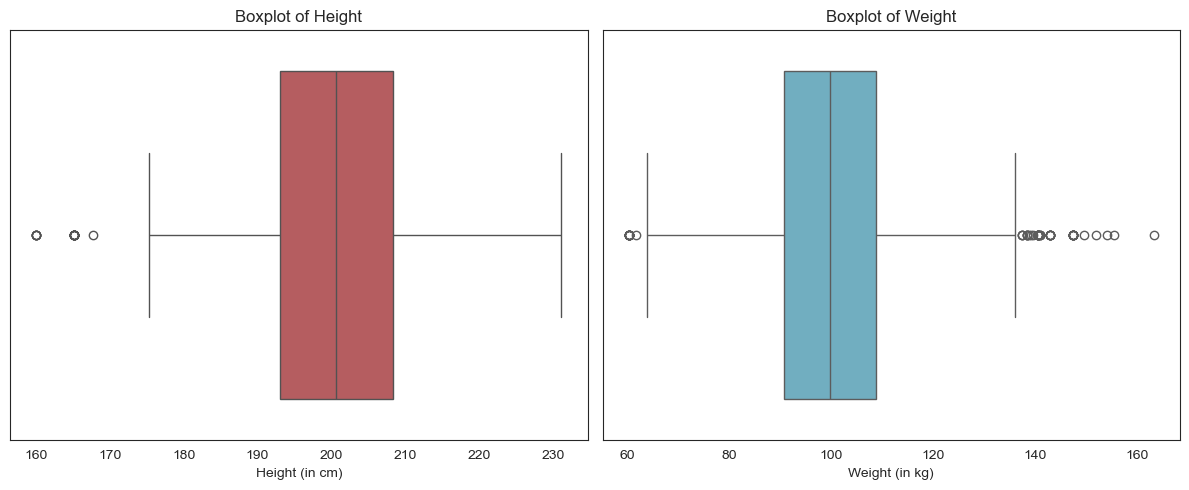

In [4]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['player_height'], color='r')
plt.title('Boxplot of Height')
plt.xlabel('Height (in cm)')

# Boxplot for weight
plt.subplot(1, 2, 2)
sns.boxplot(x=df['player_weight'], color='c')
plt.title('Boxplot of Weight')
plt.xlabel('Weight (in kg)')


plt.tight_layout()
plt.show()

In [5]:

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Defining outliers as those beyond 1.5 * IQR from the Q1 or Q3
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='player_height', y='player_weight',scatter_kws={"color": "green"}, line_kws={"color": "black"})

# Marking outliers in red
plt.scatter(df['player_height'][outliers['player_height']], df['player_weight'][outliers['player_height']], color='red', marker='x')
plt.scatter(df['player_height'][outliers['player_weight']], df['player_weight'][outliers['player_weight']], color='red', marker='x')

plt.title('Correlation between Height and Weight, filtering the outliers')
plt.xlabel('Height (in cm)')
plt.ylabel('Weight (in kg)')
plt.grid(color='grey', linestyle='--', linewidth=0.5, zorder=3)
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

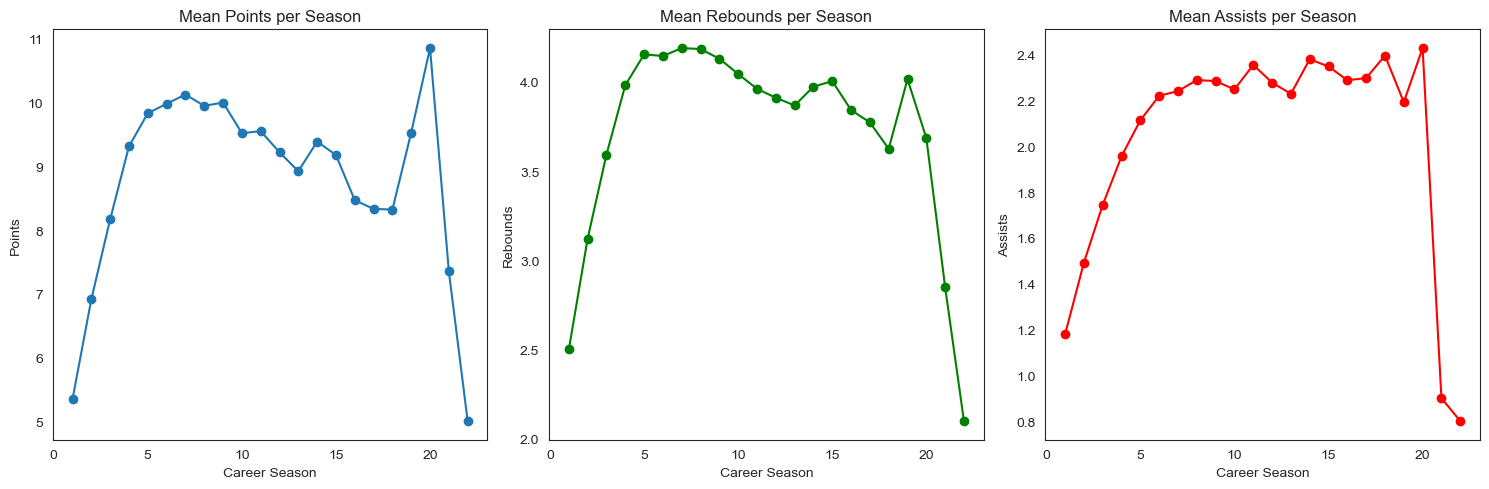

In [6]:
# Adding a column to the dataframe to represent the career season number for each player
df['career_season'] = df.groupby('player_name').cumcount() + 1

# Computing the mean stats for 'pts', 'reb', and 'ast' for each career season
mean_career_evolution = df.groupby('career_season').mean(numeric_only=True)[['pts', 'reb', 'ast']]

# Plotting the mean career evolution
plt.figure(figsize=(15, 5))

# Mean Points (pts) per career season
plt.subplot(1, 3, 1)
plt.plot(mean_career_evolution['pts'], marker='o')
plt.title('Mean Points per Season')
plt.xlabel('Career Season')
plt.ylabel('Points')

# Mean Rebounds (reb) per career season
plt.subplot(1, 3, 2)
plt.plot(mean_career_evolution['reb'], marker='o', color='green')
plt.title('Mean Rebounds per Season')
plt.xlabel('Career Season')
plt.ylabel('Rebounds')

# Mean Assists (ast) per career season
plt.subplot(1, 3, 3)
plt.plot(mean_career_evolution['ast'], marker='o', color='red')
plt.title('Mean Assists per Season')
plt.xlabel('Career Season')
plt.ylabel('Assists')

plt.tight_layout()
plt.show()


In [7]:
#https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
#Goldsberry work

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

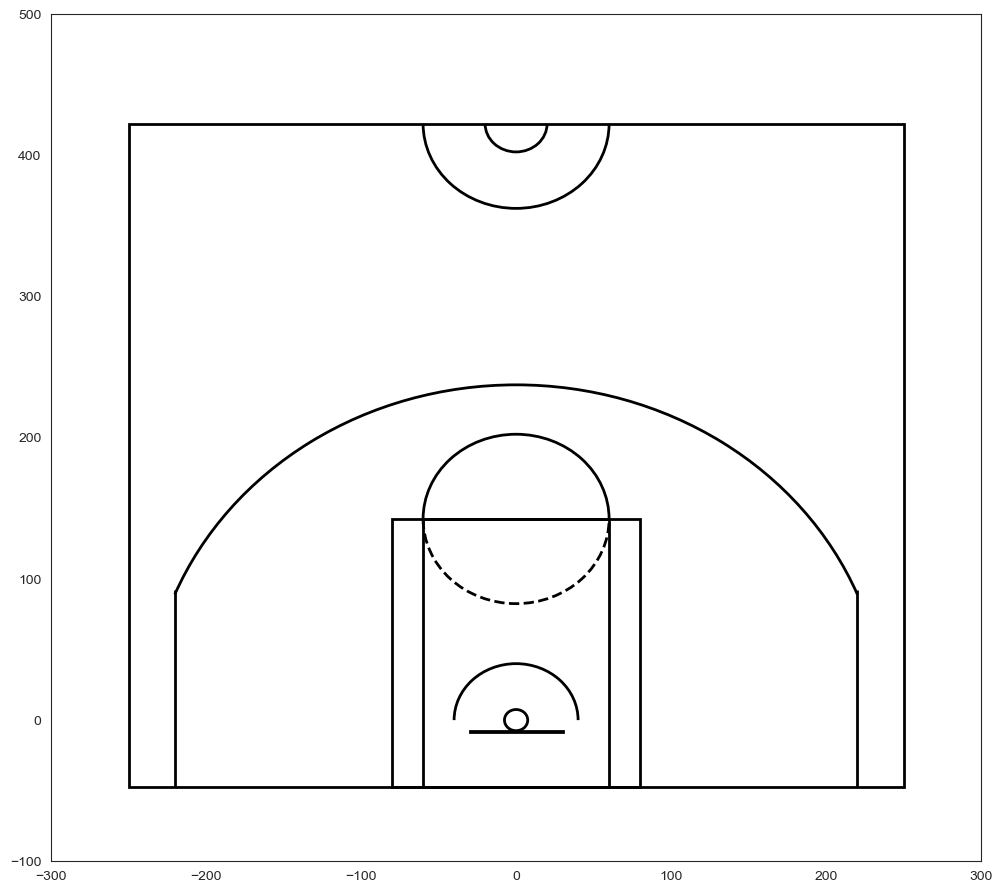

In [8]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True, color="black")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

In [9]:
def get_player_shotchartdetail(player_name, season_id):
    """
    Parameters
    ----------
    player_name: name of the player with Capital
    season_id: ex. 2012-13
    """
    
    # player dictionary
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
    
    # career df
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]
    
    # team id during the season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # shotchardtdetail endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=int(player_dict['id']), 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]

In [10]:
damianlillard2020, league_avg = get_player_shotchartdetail('Damian Lillard', '2021-22')



C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id),


In [11]:
league_avg

GRID_TYPE        SHOT_ZONE_BASIC         SHOT_ZONE_AREA  \
0   League Averages      Above the Break 3         Back Court(BC)   
1   League Averages      Above the Break 3              Center(C)   
2   League Averages      Above the Break 3   Left Side Center(LC)   
3   League Averages      Above the Break 3  Right Side Center(RC)   
4   League Averages              Backcourt         Back Court(BC)   
5   League Averages  In The Paint (Non-RA)              Center(C)   
6   League Averages  In The Paint (Non-RA)              Center(C)   
7   League Averages  In The Paint (Non-RA)           Left Side(L)   
8   League Averages  In The Paint (Non-RA)          Right Side(R)   
9   League Averages          Left Corner 3           Left Side(L)   
10  League Averages              Mid-Range              Center(C)   
11  League Averages              Mid-Range              Center(C)   
12  League Averages              Mid-Range   Left Side Center(LC)   
13  League Averages              Mid-Range           Left Side(L)   
14  League Averages              Mid-Range           Left Side(L)   
15  League Averages              Mid-Range  Right Side Center(RC)   
16  League Averages              Mid-Range          Right Side(R)   
17  League Averages              Mid-Range          Right Side(R)   
18  League Averages        Restricted Area              Center(C)   
19  League Averages         Right Corner 3          Right Side(R)   

    SHOT_ZONE_RANGE    FGA    FGM  FG_PCT  
0   Back Court Shot     35      4   0.114  
1           24+ ft.  16368   5613   0.343  
2           24+ ft.  24924   8511   0.341  
3           24+ ft.  23120   8171   0.353  
4   Back Court Shot    440     11   0.025  
5          8-16 ft.  11777   5228   0.444  
6   Less Than 8 ft.  23351   9813   0.420  
7          8-16 ft.   2197    949   0.432  
8          8-16 ft.   2343   1000   0.427  
9           24+ ft.  11377   4371   0.384  
10        16-24 ft.   4165   1743   0.418  
11         8-16 ft.   2088    921   0.441  
12        16-24 ft.   3972   1632   0.411  
13        16-24 ft.   1680    613   0.365  
14         8-16 ft.   5014   2023   0.403  
15        16-24 ft.   4043   1575   0.390  
16        16-24 ft.   1609    614   0.382  
17         8-16 ft.   5141   2143   0.417  
18  Less Than 8 ft.  62987  41140   0.653  
19          24+ ft.  10091   3855   0.382

In [12]:
# Correct the function with the right column name
def calculate_ppa_corrected(row):
    if row['SHOT_ZONE_BASIC'] == 'Above the Break 3':
        return row['FG_PCT'] * 3
    else:
        return row['FG_PCT'] * 2

# Apply the corrected function to the dataframe
league_avg['PPA'] = league_avg.apply(calculate_ppa_corrected, axis=1)

# Display the first few rows of the updated dataframe
league_avg.head()

GRID_TYPE    SHOT_ZONE_BASIC         SHOT_ZONE_AREA  SHOT_ZONE_RANGE  \
0  League Averages  Above the Break 3         Back Court(BC)  Back Court Shot   
1  League Averages  Above the Break 3              Center(C)          24+ ft.   
2  League Averages  Above the Break 3   Left Side Center(LC)          24+ ft.   
3  League Averages  Above the Break 3  Right Side Center(RC)          24+ ft.   
4  League Averages          Backcourt         Back Court(BC)  Back Court Shot   

     FGA   FGM  FG_PCT    PPA  
0     35     4   0.114  0.342  
1  16368  5613   0.343  1.029  
2  24924  8511   0.341  1.023  
3  23120  8171   0.353  1.059  
4    440    11   0.025  0.050

In [13]:
league_avg['PPA'] = league_avg['PPA'].round(2)

In [14]:
def get_zone_position(zone):
    # Define positions for each zone
    positions = {
        'Above the Break 3\nCenter(C)': (0, 250),
        'Above the Break 3\nLeft Side Center(LC)': (-150, 200),
        'Above the Break 3\nRight Side Center(RC)': (150, 200),
        'Backcourt\nBack Court(BC)': (0, 420),
        'Mid-Range\nCenter(C)': (0, 125),
        'Mid-Range\nLeft Side(L)': (-150, 0),
        'Mid-Range\nRight Side(R)': (150, 0),
        'Mid-Range\nLeft Side Center(LC)': (-130, 125),
        'Mid-Range\nRight Side Center(RC)': (130, 125),
        'In The Paint (Non-RA)\nCenter(C)': (0, 50),
        'Restricted Area\nCenter(C)': (0, 0),
        'Left Corner 3\nLeft Side(L)': (-230, 0),
        'Right Corner 3\nRight Side(R)': (230, 0)
    }

    return positions.get(zone, (None, None))

In [15]:
def plot_shot_zones(df, ax):
    # Define zones
    zones = df.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).mean().reset_index()

    # Plot each zone with its FG_PCT
    for index, row in zones.iterrows():
        zone = row['SHOT_ZONE_BASIC'] + '\n' + row['SHOT_ZONE_AREA']
        fg_pct = row['FG_PCT']
        x, y = get_zone_position(zone)

        if pd.notna(x) and pd.notna(y):
            ax.text(x, y, f'{fg_pct:.1%}', color='black', ha='center', va='center')

    return ax


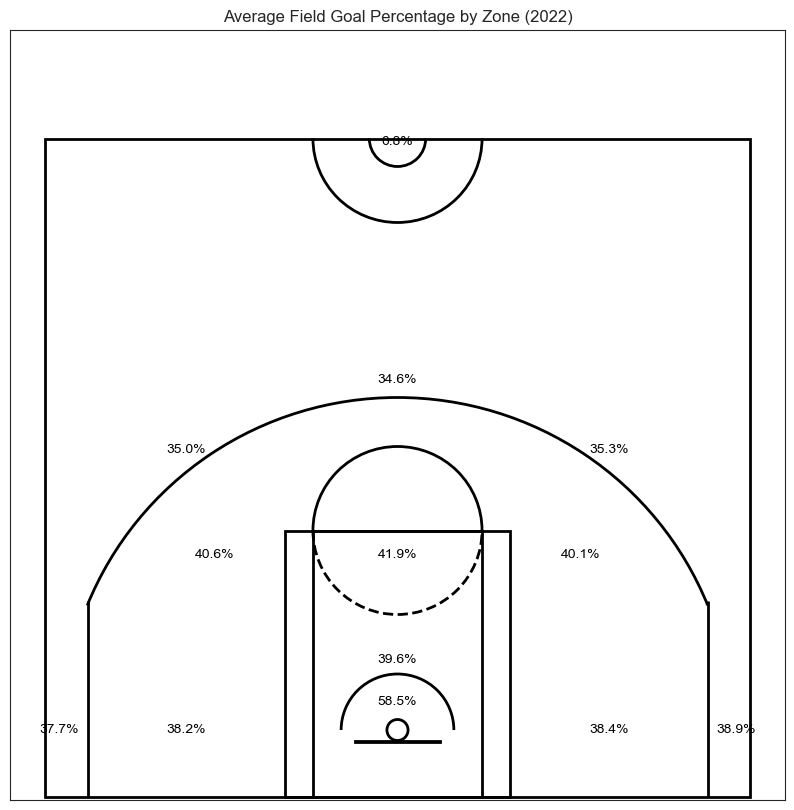

In [162]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax



def plot_shot_zones(df, ax):
    # Define zones
    zones = df.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).mean(numeric_only=True).reset_index()

    # Plot each zone with its FG_PCT
    for index, row in zones.iterrows():
        zone = row['SHOT_ZONE_BASIC'] + '\n' + row['SHOT_ZONE_AREA']
        fg_pct = row['FG_PCT']
        x, y = get_zone_position(zone)

        if pd.notna(x) and pd.notna(y):
            ax.text(x, y, f'{fg_pct:.1%}', color='black', ha='center', va='center')

    return ax


def get_zone_position(zone):
    # Define positions for each zone
    positions = {
        'Above the Break 3\nCenter(C)': (0, 250),
        'Above the Break 3\nLeft Side Center(LC)': (-150, 200),
        'Above the Break 3\nRight Side Center(RC)': (150, 200),
        'Backcourt\nBack Court(BC)': (0, 420),
        'Mid-Range\nCenter(C)': (0, 125),
        'Mid-Range\nLeft Side(L)': (-150, 0),
        'Mid-Range\nRight Side(R)': (150, 0),
        'Mid-Range\nLeft Side Center(LC)': (-130, 125),
        'Mid-Range\nRight Side Center(RC)': (130, 125),
        'In The Paint (Non-RA)\nCenter(C)': (0, 50),
        'Restricted Area\nCenter(C)': (0, 20),
        'Left Corner 3\nLeft Side(L)': (-240, 0),
        'Right Corner 3\nRight Side(R)': (240, 0)
    }

    return positions.get(zone, (None, None))



fig, ax = plt.subplots(figsize=(10, 10))
ax = draw_court(ax, outer_lines=True)
ax = plot_shot_zones(league_avg_2005, ax)
ax.set_xlim(-275, 275)
ax.set_ylim(-50, 500)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Field Goal Percentage by Zone (2022)')

plt.show()

KeyError: 'PPA'

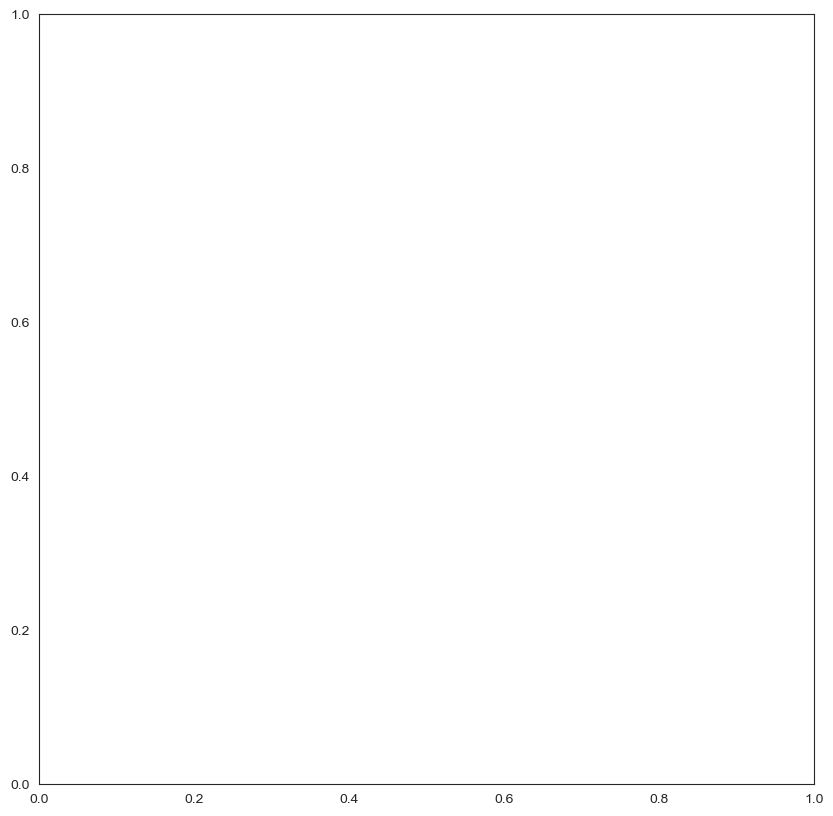

In [108]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax



def plot_point_zones(league_avg, ax):
    # Define zones
    zones = league_avg.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).mean(numeric_only=True).reset_index()

    # Plot each zone with its FG_PCT
    for index, row in zones.iterrows():
        zone = row['SHOT_ZONE_BASIC'] + '\n' + row['SHOT_ZONE_AREA']
        fg_pct = row['PPA']
        x, y = get_zone_position(zone)

        if pd.notna(x) and pd.notna(y):
            ax.text(x, y, f'{fg_pct:}', color='black', ha='center', va='center')

    return ax


def get_zone_position(zone):
    # Define positions for each zone
    positions = {
        'Above the Break 3\nCenter(C)': (0, 250),
        'Above the Break 3\nLeft Side Center(LC)': (-150, 200),
        'Above the Break 3\nRight Side Center(RC)': (150, 200),
        'Backcourt\nBack Court(BC)': (0, 420),
        'Mid-Range\nCenter(C)': (0, 125),
        'Mid-Range\nLeft Side(L)': (-150, 0),
        'Mid-Range\nRight Side(R)': (150, 0),
        'Mid-Range\nLeft Side Center(LC)': (-130, 125),
        'Mid-Range\nRight Side Center(RC)': (130, 125),
        'In The Paint (Non-RA)\nCenter(C)': (0, 50),
        'Restricted Area\nCenter(C)': (0, 20),
        'Left Corner 3\nLeft Side(L)': (-240, 0),
        'Right Corner 3\nRight Side(R)': (240, 0)
    }

    return positions.get(zone, (None, None))



fig, ax = plt.subplots(figsize=(10, 10))
ax = draw_court(ax, outer_lines=True)
ax = plot_point_zones(league_avg, ax)
ax.set_xlim(-275, 275)
ax.set_ylim(-50, 500)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Field Goal Percentage by Zone (2022)')

plt.show()

In [18]:
steve_nash, league_avg_2005 = get_player_shotchartdetail('Steve Nash', '2004-05')


C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id),


In [19]:
league_avg_2005

GRID_TYPE        SHOT_ZONE_BASIC         SHOT_ZONE_AREA  \
0   League Averages      Above the Break 3         Back Court(BC)   
1   League Averages      Above the Break 3              Center(C)   
2   League Averages      Above the Break 3   Left Side Center(LC)   
3   League Averages      Above the Break 3  Right Side Center(RC)   
4   League Averages              Backcourt         Back Court(BC)   
5   League Averages  In The Paint (Non-RA)              Center(C)   
6   League Averages  In The Paint (Non-RA)              Center(C)   
7   League Averages  In The Paint (Non-RA)           Left Side(L)   
8   League Averages  In The Paint (Non-RA)          Right Side(R)   
9   League Averages          Left Corner 3           Left Side(L)   
10  League Averages              Mid-Range              Center(C)   
11  League Averages              Mid-Range              Center(C)   
12  League Averages              Mid-Range   Left Side Center(LC)   
13  League Averages              Mid-Range           Left Side(L)   
14  League Averages              Mid-Range           Left Side(L)   
15  League Averages              Mid-Range  Right Side Center(RC)   
16  League Averages              Mid-Range          Right Side(R)   
17  League Averages              Mid-Range          Right Side(R)   
18  League Averages        Restricted Area              Center(C)   
19  League Averages         Right Corner 3          Right Side(R)   

    SHOT_ZONE_RANGE    FGA    FGM  FG_PCT  
0   Back Court Shot    115      2   0.017  
1           24+ ft.   5850   2027   0.346  
2           24+ ft.  10956   3840   0.350  
3           24+ ft.  10539   3717   0.353  
4   Back Court Shot    363      3   0.008  
5          8-16 ft.   5303   2099   0.396  
6   Less Than 8 ft.  16703   6636   0.397  
7          8-16 ft.   1918    787   0.410  
8          8-16 ft.   1834    725   0.395  
9           24+ ft.   5541   2090   0.377  
10        16-24 ft.   6879   2790   0.406  
11         8-16 ft.   1894    817   0.431  
12        16-24 ft.  10027   4066   0.406  
13        16-24 ft.  10302   4044   0.393  
14         8-16 ft.  11101   4131   0.372  
15        16-24 ft.  10601   4255   0.401  
16        16-24 ft.   8849   3516   0.397  
17         8-16 ft.  10381   3850   0.371  
18  Less Than 8 ft.  63163  36974   0.585  
19          24+ ft.   5307   2066   0.389

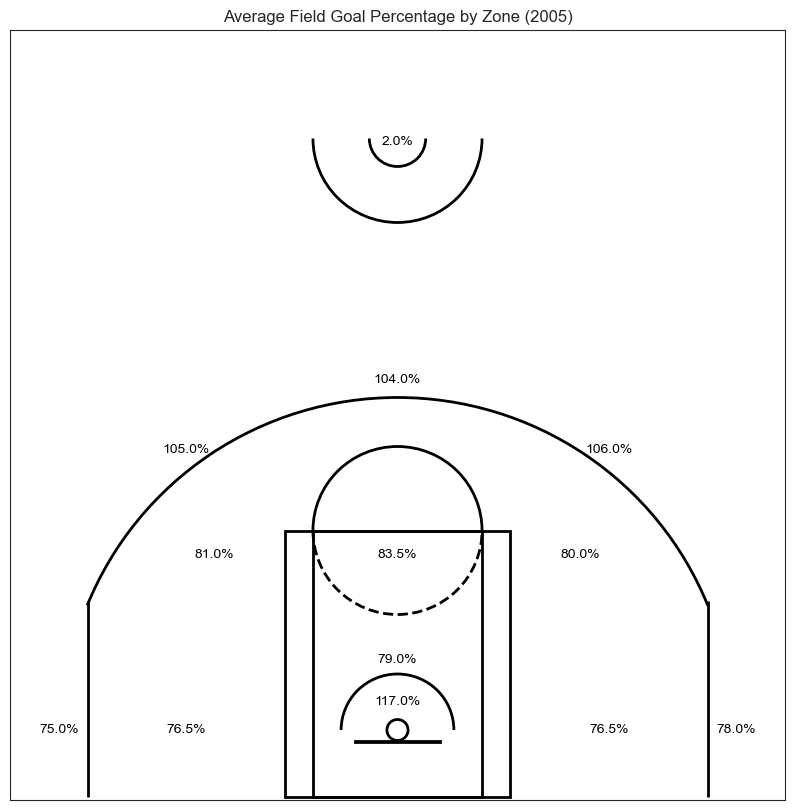

In [23]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax



def plot_shot_zones(league_avg_2005, ax):
    # Define zones
    zones = league_avg_2005.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).mean(numeric_only=True).reset_index()

    # Plot each zone with its FG_PCT
    for index, row in zones.iterrows():
        zone = row['SHOT_ZONE_BASIC'] + '\n' + row['SHOT_ZONE_AREA']
        fg_pct = row['PPA']
        x, y = get_zone_position(zone)

        if pd.notna(x) and pd.notna(y):
            ax.text(x, y, f'{fg_pct:.1%}', color='black', ha='center', va='center')

    return ax


def get_zone_position(zone):
    # Define positions for each zone
    positions = {
        'Above the Break 3\nCenter(C)': (0, 250),
        'Above the Break 3\nLeft Side Center(LC)': (-150, 200),
        'Above the Break 3\nRight Side Center(RC)': (150, 200),
        'Backcourt\nBack Court(BC)': (0, 420),
        'Mid-Range\nCenter(C)': (0, 125),
        'Mid-Range\nLeft Side(L)': (-150, 0),
        'Mid-Range\nRight Side(R)': (150, 0),
        'Mid-Range\nLeft Side Center(LC)': (-130, 125),
        'Mid-Range\nRight Side Center(RC)': (130, 125),
        'In The Paint (Non-RA)\nCenter(C)': (0, 50),
        'Restricted Area\nCenter(C)': (0, 20),
        'Left Corner 3\nLeft Side(L)': (-240, 0),
        'Right Corner 3\nRight Side(R)': (240, 0)
    }

    return positions.get(zone, (None, None))



fig, ax = plt.subplots(figsize=(10, 10))
ax = draw_court(ax)
ax = plot_shot_zones(league_avg_2005, ax)
ax.set_xlim(-275, 275)
ax.set_ylim(-50, 500)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Field Goal Percentage by Zone (2005)')

plt.show()

In [24]:
# Correct the function with the right column name
def calculate_ppa_corrected(row):
    if row['SHOT_ZONE_BASIC'] == 'Above the Break 3':
        return row['FG_PCT'] * 3
    else:
        return row['FG_PCT'] * 2

# Apply the corrected function to the dataframe
league_avg_2005['PPA'] = league_avg_2005.apply(calculate_ppa_corrected, axis=1)

# Display the first few rows of the updated dataframe
league_avg_2005.head()

league_avg_2005['PPA'] = league_avg_2005['PPA'].round(2)

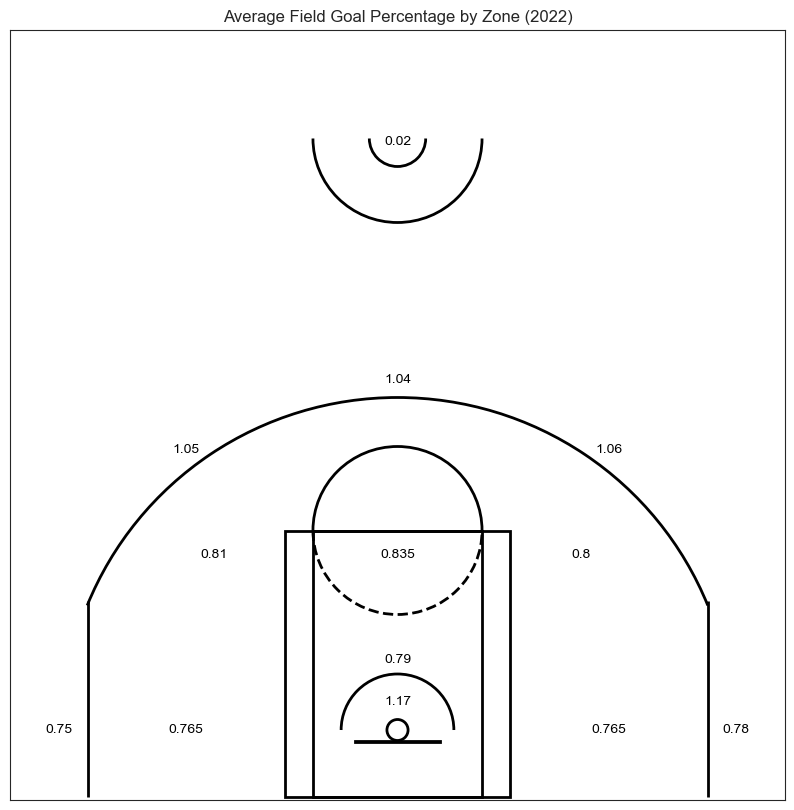

In [25]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax



def plot_point_zones(league_avg_2005, ax):
    # Define zones
    zones = league_avg_2005.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).mean(numeric_only=True).reset_index()

    # Plot each zone with its FG_PCT
    for index, row in zones.iterrows():
        zone = row['SHOT_ZONE_BASIC'] + '\n' + row['SHOT_ZONE_AREA']
        fg_pct = row['PPA']
        x, y = get_zone_position(zone)

        if pd.notna(x) and pd.notna(y):
            ax.text(x, y, f'{fg_pct:}', color='black', ha='center', va='center')

    return ax


def get_zone_position(zone):
    # Define positions for each zone
    positions = {
        'Above the Break 3\nCenter(C)': (0, 250),
        'Above the Break 3\nLeft Side Center(LC)': (-150, 200),
        'Above the Break 3\nRight Side Center(RC)': (150, 200),
        'Backcourt\nBack Court(BC)': (0, 420),
        'Mid-Range\nCenter(C)': (0, 125),
        'Mid-Range\nLeft Side(L)': (-150, 0),
        'Mid-Range\nRight Side(R)': (150, 0),
        'Mid-Range\nLeft Side Center(LC)': (-130, 125),
        'Mid-Range\nRight Side Center(RC)': (130, 125),
        'In The Paint (Non-RA)\nCenter(C)': (0, 50),
        'Restricted Area\nCenter(C)': (0, 20),
        'Left Corner 3\nLeft Side(L)': (-240, 0),
        'Right Corner 3\nRight Side(R)': (240, 0)
    }

    return positions.get(zone, (None, None))



fig, ax = plt.subplots(figsize=(10, 10))
ax = draw_court(ax)
ax = plot_point_zones(league_avg_2005, ax)
ax.set_xlim(-275, 275)
ax.set_ylim(-50, 500)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Field Goal Percentage by Zone (2022)')

plt.show()

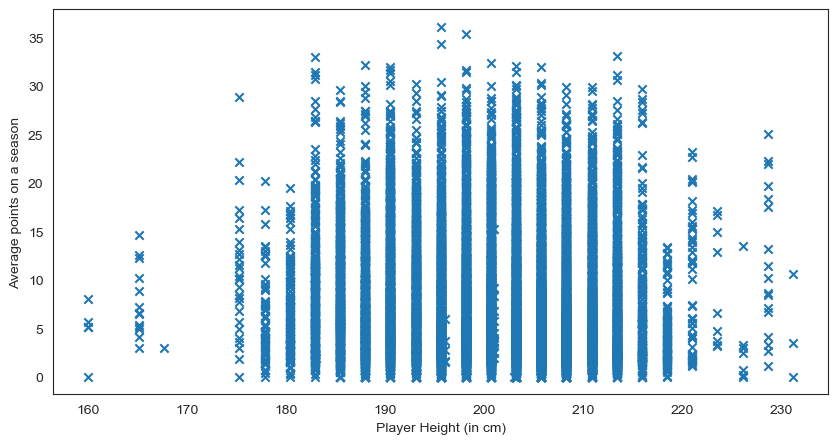

In [26]:
plt.figure(figsize=(10,5))
plt.scatter(df['player_height'], df['pts'],  marker='x')
plt.xlabel('Player Height (in cm)')
plt.ylabel('Average points on a season')
plt.show()


In [27]:
# Grouping the data by player's name and calculating the mean of the points, rebounds, and assists
mean_stats = df.groupby('player_name').agg({
    'pts': 'mean',
    'reb': 'mean',
    'ast': 'mean',
    'player_height': 'mean',
    'player_weight': 'mean'
}).reset_index()

# Renaming the columns for clarity
mean_stats.rename(columns={'pts': 'mean_pts', 'reb': 'mean_reb', 'ast': 'mean_ast'}, inplace=True)

mean_stats.head()

player_name  mean_pts  mean_reb  mean_ast  player_height  player_weight
0     A.C. Green      5.78      6.06  0.860000         205.74     102.058200
1  A.J. Bramlett      1.00      2.80  0.000000         208.28     102.965384
2    A.J. Guyton      3.80      0.70  1.566667         185.42      81.646560
3    A.J. Lawson      3.70      1.40  0.100000         198.12      81.192968
4       AJ Green      4.40      1.30  0.600000         195.58      86.182480

Text(0.5, 1.0, 'Height vs Mean Assists\nCorrelation Coefficient: -0.42')

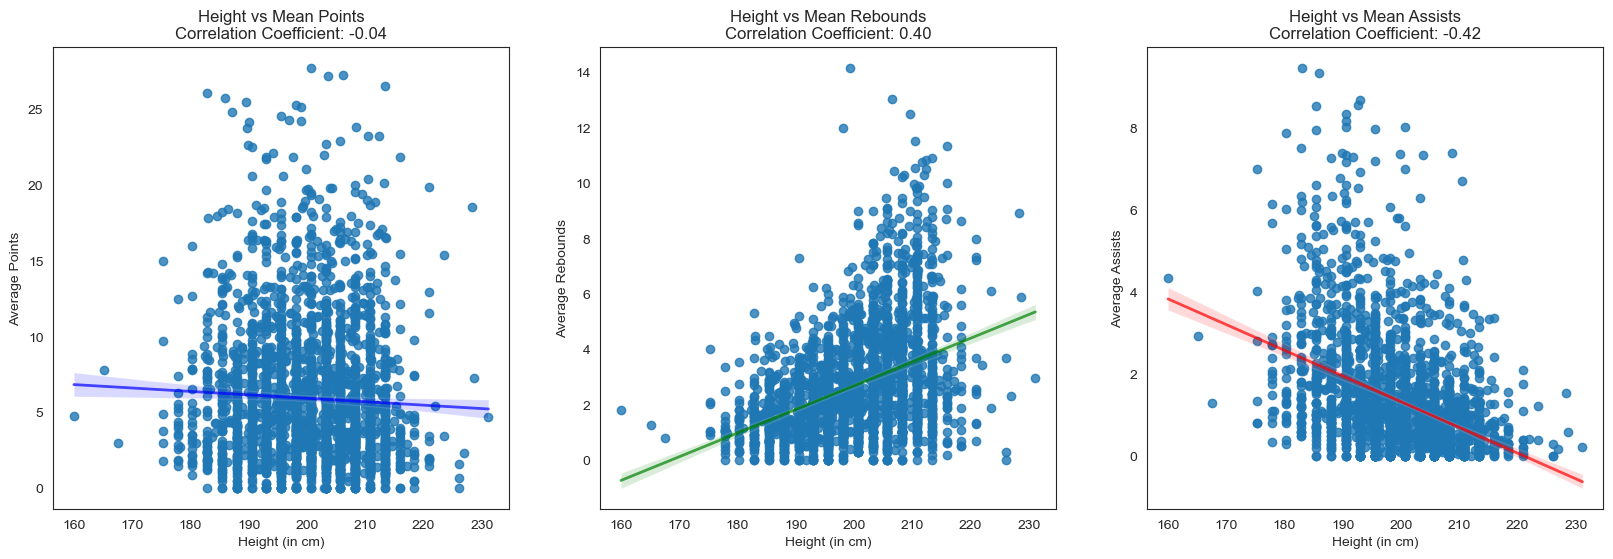

In [28]:
from scipy.stats import pearsonr

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
sns.regplot(x=mean_stats['player_height'], y=mean_stats['mean_pts'], line_kws={"color":"blue","alpha":0.7,"lw":2})
plt.xlabel('Height (in cm)')
plt.ylabel('Average Points')
plt.title('Height vs Mean Points\nCorrelation Coefficient: {:.2f}'.format(pearsonr(mean_stats['player_height'], mean_stats['mean_pts'])[0]))

plt.subplot(1,3,2)
sns.regplot(x=mean_stats['player_height'], y=mean_stats['mean_reb'], line_kws={"color":"green","alpha":0.7,"lw":2})
plt.xlabel('Height (in cm)')
plt.ylabel('Average Rebounds')
plt.title('Height vs Mean Rebounds\nCorrelation Coefficient: {:.2f}'.format(pearsonr(mean_stats['player_height'], mean_stats['mean_reb'])[0]))

plt.subplot(1,3,3)
sns.regplot(x=mean_stats['player_height'], y=mean_stats['mean_ast'], line_kws={"color":"red","alpha":0.7,"lw":2})
plt.xlabel('Height (in cm)')
plt.ylabel('Average Assists')
plt.title('Height vs Mean Assists\nCorrelation Coefficient: {:.2f}'.format(pearsonr(mean_stats['player_height'], mean_stats['mean_ast'])[0]))

In [29]:
corr_w_r = df.groupby('season')[['player_weight','reb']].corr().unstack().iloc[:,1]
corr_w_a = df.groupby('season')[['player_weight','ast']].corr().unstack().iloc[:,1]

corr_h_r = df.groupby('season')[['player_height','reb']].corr().unstack().iloc[:,1]
corr_h_a = df.groupby('season')[['player_height','ast']].corr().unstack().iloc[:,1]

fig = go.Figure()
fig.add_trace(go.Scatter(x=corr_w_r.index, 
                         y=corr_w_r.values,
                         mode='lines',
                         name='Weight and Rebounds'))
                        

fig.add_trace(go.Scatter(x=corr_w_a.index, 
                         y=corr_w_a.values,
                         mode='lines',
                         name='Weight and Assists'))
                    
                        

fig.add_trace(go.Scatter(x=corr_h_r.index, 
                         y=corr_h_r.values,
                         mode='lines',
                         name='Height and Rebounds'))
                        
                        

fig.add_trace(go.Scatter(x=corr_h_a.index, 
                         y=corr_h_a.values,
                         mode='lines',
                         name='Height and Assists'))
                
                        

fig.update_layout(
    title='NBA Player Height and Points Correlation Each Season',
    xaxis_title='Season',
    yaxis_title='Correlation',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


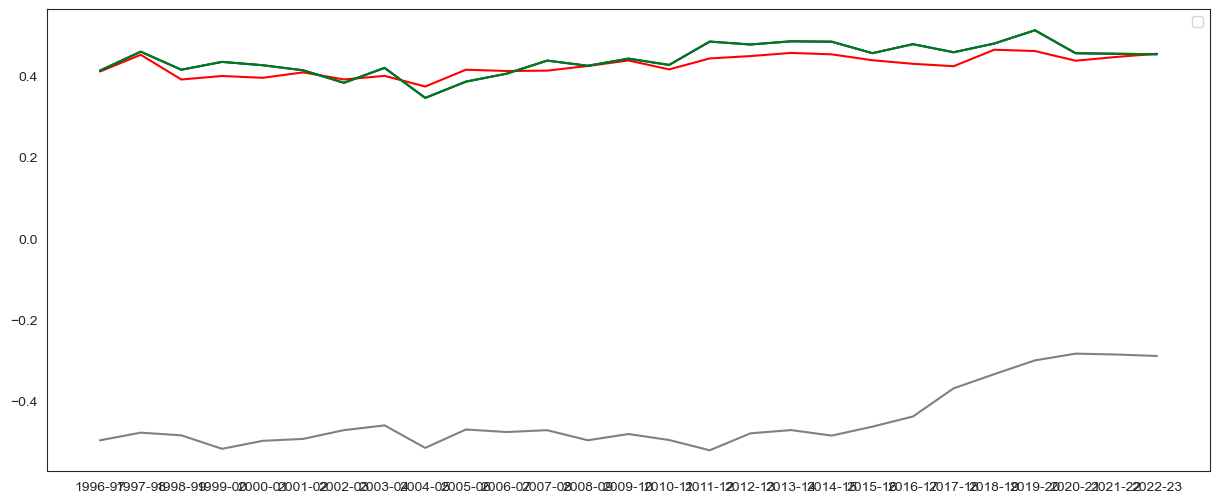

In [30]:
plt.figure(figsize=(15,6))

plt.plot(corr_h_r.index, corr_h_r.values, color='red')
plt.plot(corr_w_r.index, corr_w_r.values, color='blue')
plt.plot(corr_h_a.index, corr_h_a.values, color='grey')
plt.plot(corr_w_r.index, corr_w_r.values, color='green')

plt.legend()
plt.show()

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()

mean_stats[['std_height', 'std_weight']] = scaler.fit_transform(mean_stats[['player_height', 'player_weight']])

In [32]:
def optimise_k_means(data, max_k):
    means=[]
    inertias=[]

    for k in range (1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

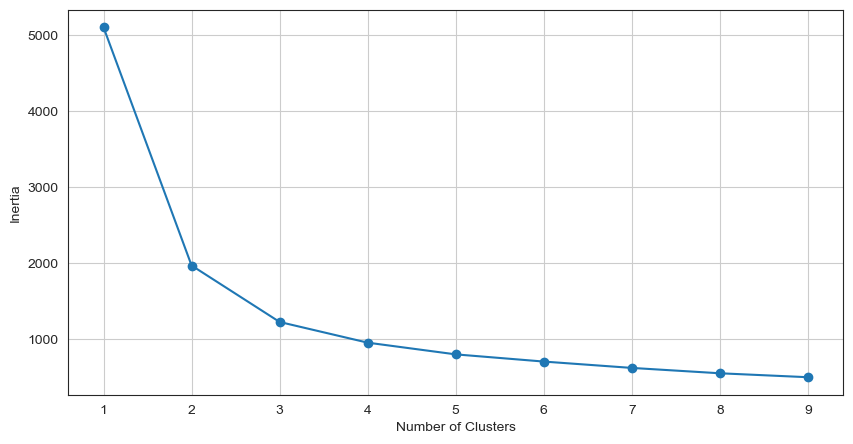

In [33]:
optimise_k_means(mean_stats[['std_height', 'std_weight']], 10)

In [34]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(mean_stats[['std_height', 'std_weight']])

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=3)

In [35]:
mean_stats['kmeans_3'] = kmeans.labels_

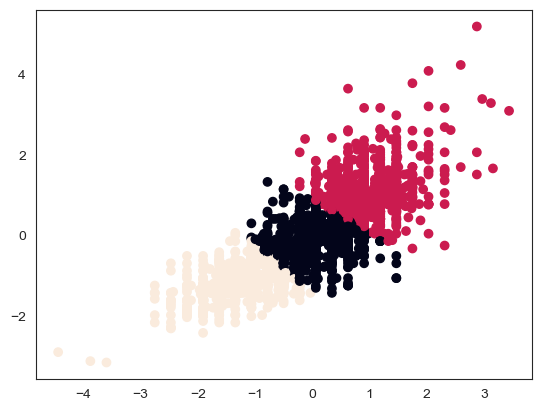

In [36]:
plt.scatter(x=mean_stats['std_height'], y=mean_stats['std_weight'], c=mean_stats['kmeans_3'])
plt.show()

In [37]:
for k in range(1,6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(mean_stats[['std_height', 'std_weight']])
    mean_stats[f'KMeans_{k}'] = kmeans.labels_ 

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

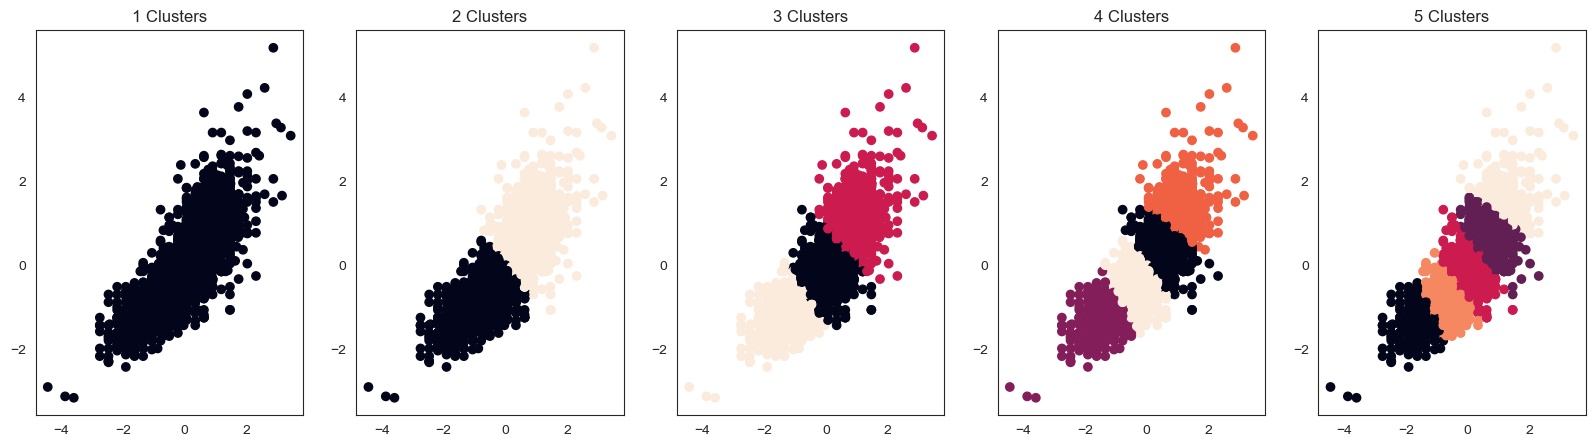

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

for i, ax in enumerate(fig.axes, start=1):
   ax.scatter(x=mean_stats['std_height'], y=mean_stats['std_weight'], c=mean_stats[f'KMeans_{i}'])
   ax.set_title(f'{i} Clusters')

In [39]:
X = mean_stats[['std_height', 'std_weight']]

In [40]:
# from sklearn.metrics import silhouette_score

# kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
# labels = kmeans.labels_

# silhouette_avg = silhouette_score(X, labels)

# silhouette_avg

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

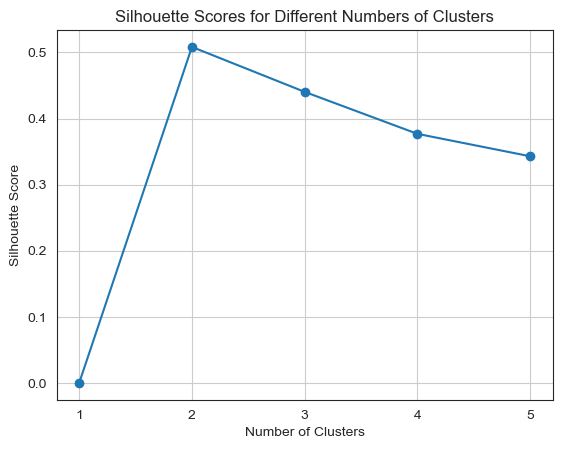

In [42]:
cluster_range = range(1, 6)

# List to store the silhouette scores for each number of clusters
silhouette_scores = []

# Calculating silhouette scores for different number of clusters
for n_clusters in cluster_range:
    if n_clusters == 1:
        # Silhouette score cannot be calculated for a single cluster
        silhouette_scores.append(0)
        continue
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for each number of cluster')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5081817226416506
For n_clusters = 3 The average silhouette_score is : 0.44032522895012255
For n_clusters = 4 The average silhouette_score is : 0.3768218290551359


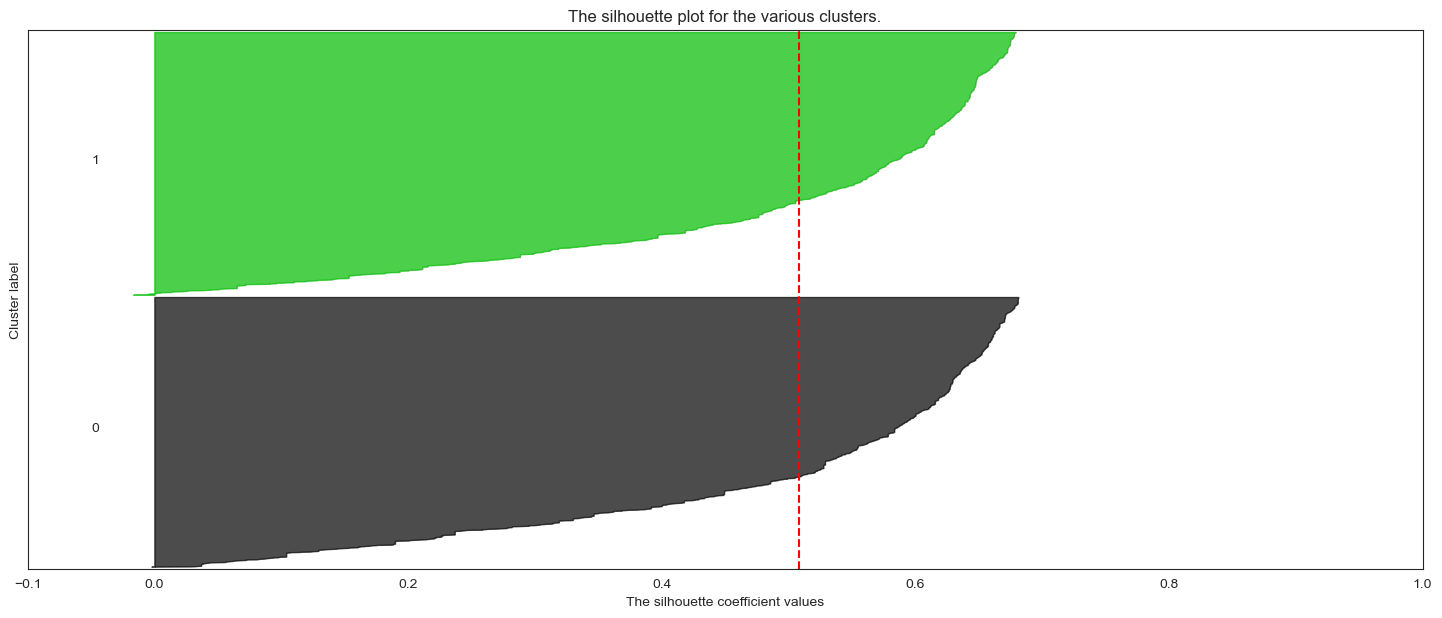

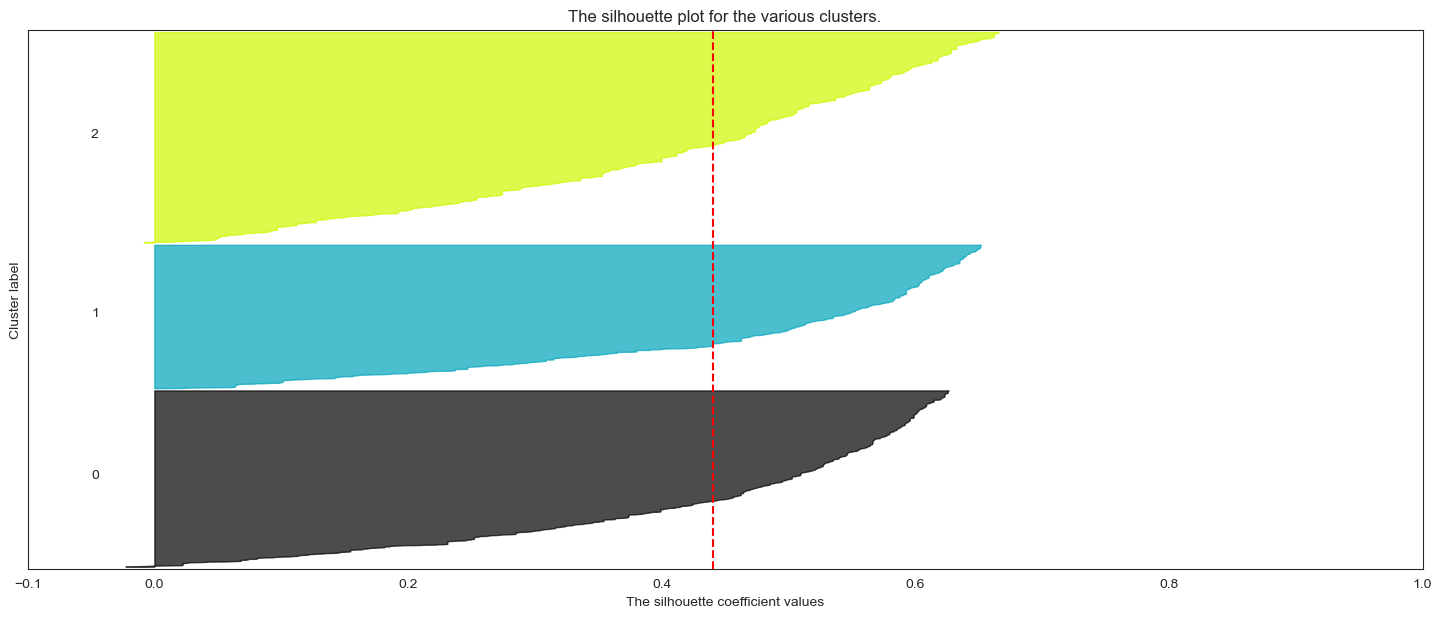

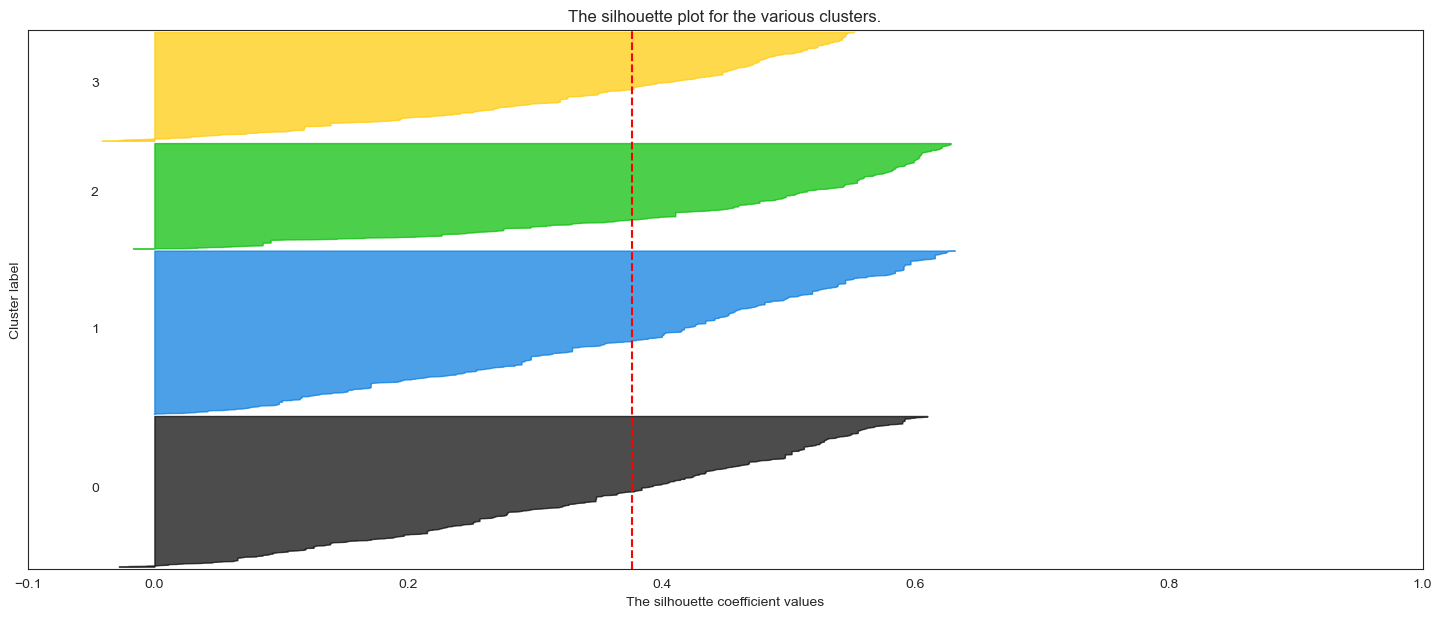

In [43]:
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,
                       n_init=100,
                       max_iter=500,
                       random_state=42)
    
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
df['season'] = pd.to_datetime(df['season'].str[:4])

In [46]:
df['season'] = pd.to_datetime(df['season']).dt.year

In [47]:
df_2005 = df[df['season'] == 2005]

In [48]:
df_2022 = df[df['season'] == 2022]

In [ ]:
df_2005[['std_height', 'std_weight']] = scaler.fit_transform(df_2005[['player_height', 'player_weight']])

In [50]:
df_2022[['std_height', 'std_weight']] = scaler.fit_transform(df_2022[['player_height', 'player_weight']])

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\3436867743.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\3436867743.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
X_2005 = df_2005[['std_height', 'std_weight']]

X_2022 = df_2022[['std_height', 'std_weight']]

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Wind

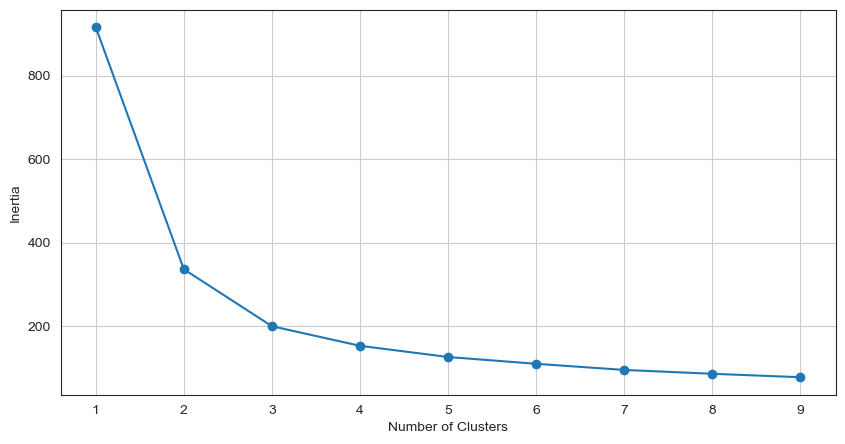

In [52]:
optimise_k_means(df_2005[['std_height', 'std_weight']], 10)

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Wind

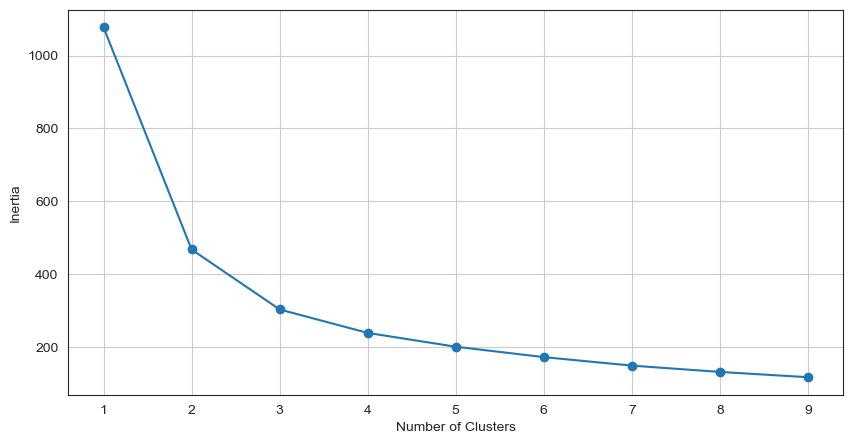

In [53]:
optimise_k_means(df_2022[['std_height', 'std_weight']], 10)

In [54]:
for k in range(1,6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(df_2005[['std_height', 'std_weight']])
    df_2005[f'KMeans_{k}'] = kmeans.labels_ 

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\1014645028.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-pac

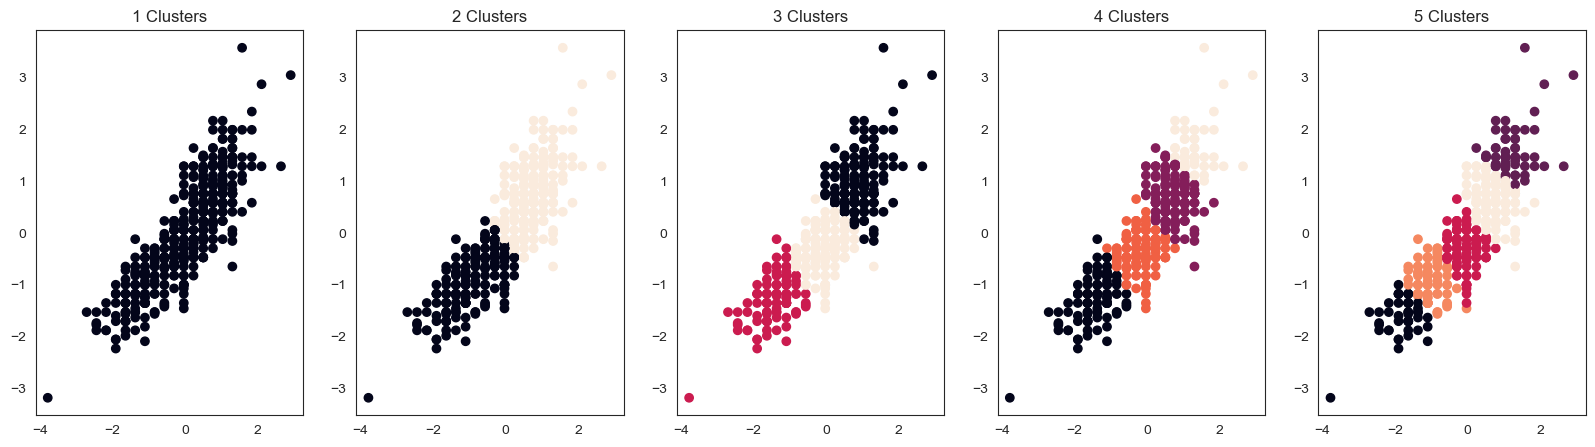

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

for i, ax in enumerate(fig.axes, start=1):
   ax.scatter(x=df_2005['std_height'], y=df_2005['std_weight'], c=df_2005[f'KMeans_{i}'])
   ax.set_title(f'{i} Clusters')

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\432805240.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-pack

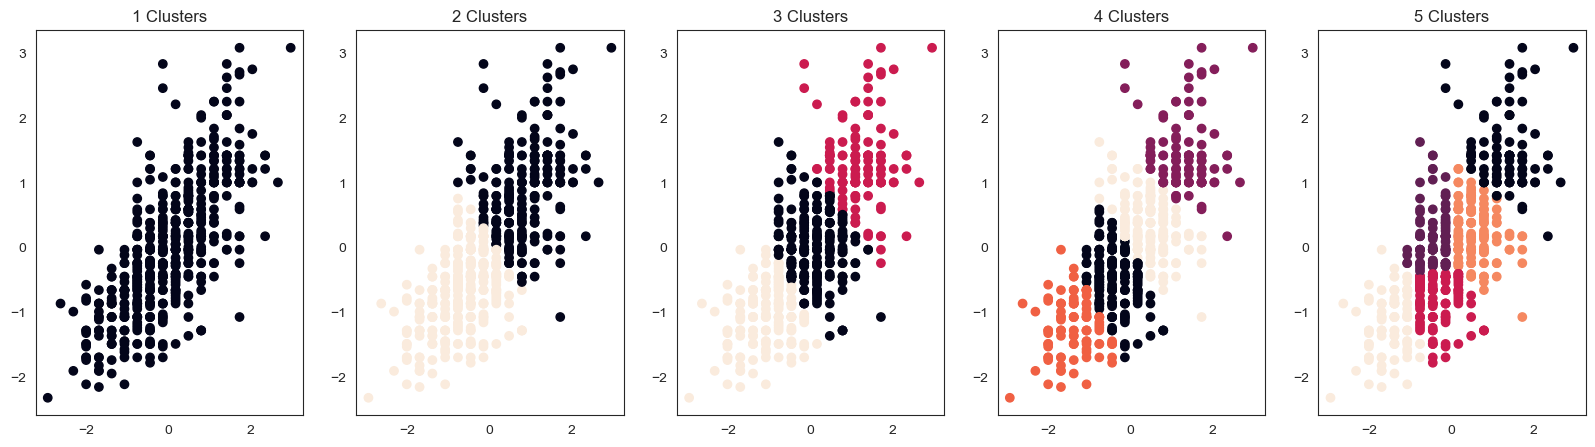

In [56]:
for k in range(1,6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(df_2022[['std_height', 'std_weight']])
    df_2022[f'KMeans_{k}'] = kmeans.labels_ 


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

for i, ax in enumerate(fig.axes, start=1):
   ax.scatter(x=df_2022['std_height'], y=df_2022['std_weight'], c=df_2022[f'KMeans_{i}'])
   ax.set_title(f'{i} Clusters')

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Wind

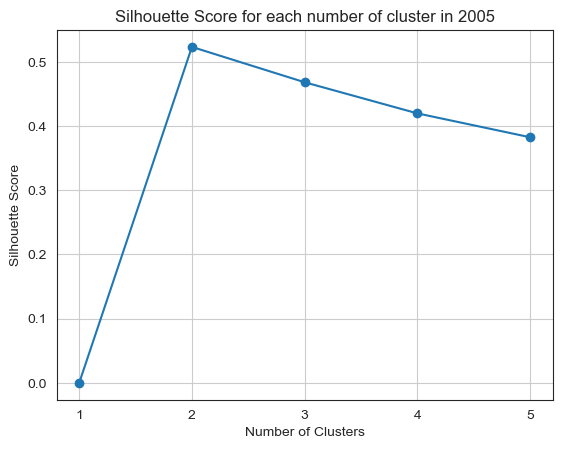

In [64]:
cluster_range = range(1, 6)

# List to store the silhouette scores for each number of clusters
silhouette_scores = []

# Calculating silhouette scores for different number of clusters
for n_clusters in cluster_range:
    if n_clusters == 1:
        # Silhouette score cannot be calculated for a single cluster
        silhouette_scores.append(0)
        continue
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_2005)
    labels = kmeans.labels_
    score = silhouette_score(X_2005, labels)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for each number of cluster in 2005')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Wind

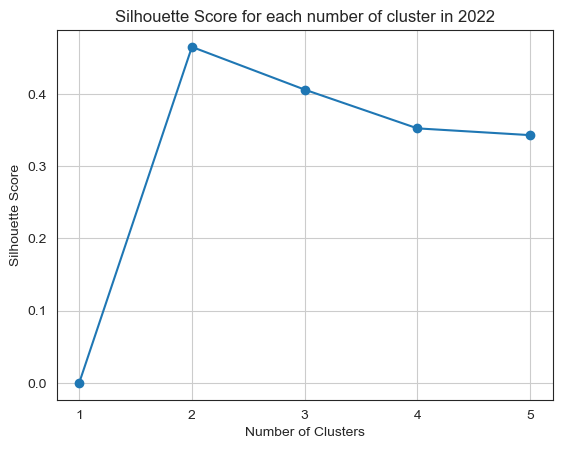

In [65]:
cluster_range = range(1, 6)

# List to store the silhouette scores for each number of clusters
silhouette_scores = []

# Calculating silhouette scores for different number of clusters
for n_clusters in cluster_range:
    if n_clusters == 1:
        # Silhouette score cannot be calculated for a single cluster
        silhouette_scores.append(0)
        continue
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_2022)
    labels = kmeans.labels_
    score = silhouette_score(X_2022, labels)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for each number of cluster in 2022')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 3 The average silhouette_score is : 0.4709400176082633


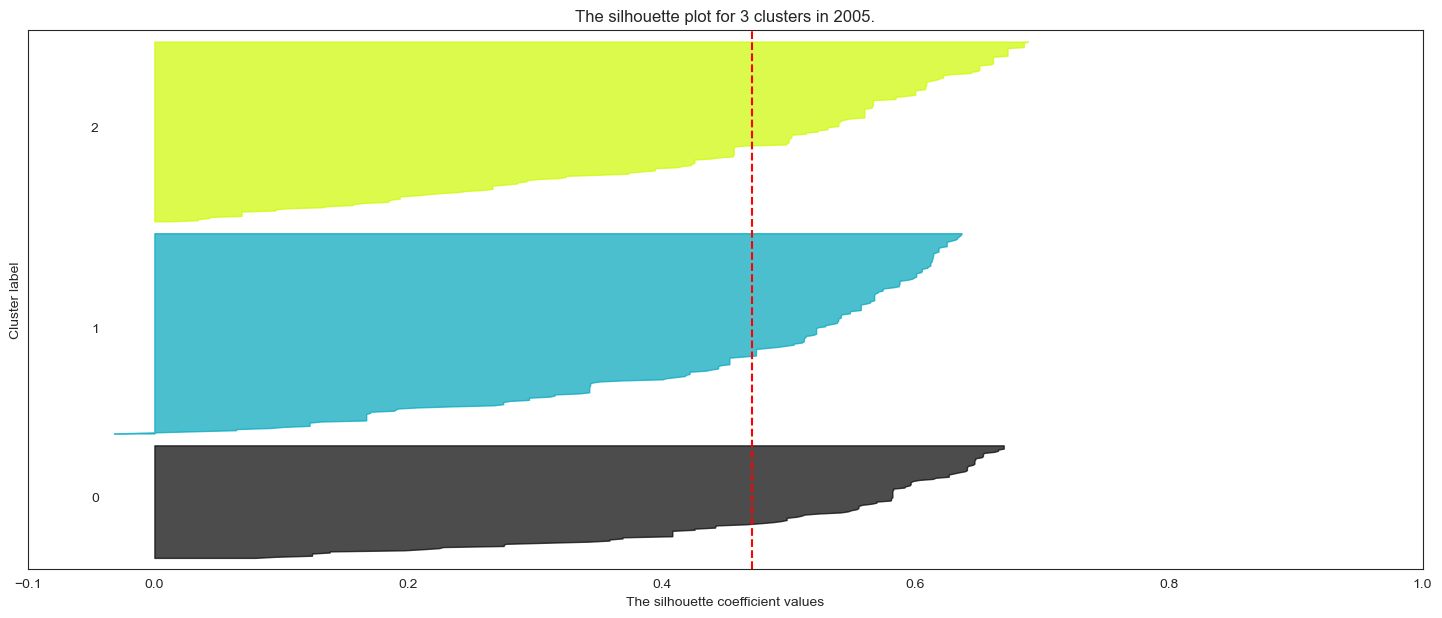

In [70]:
range_n_clusters = [3]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_2005) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,
                       n_init=100,
                       max_iter=500,
                       random_state=42)
    
    cluster_labels = clusterer.fit_predict(X_2005)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_2005, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_2005, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for 3 clusters in 2005.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



For n_clusters = 3 The average silhouette_score is : 0.40517521170365656


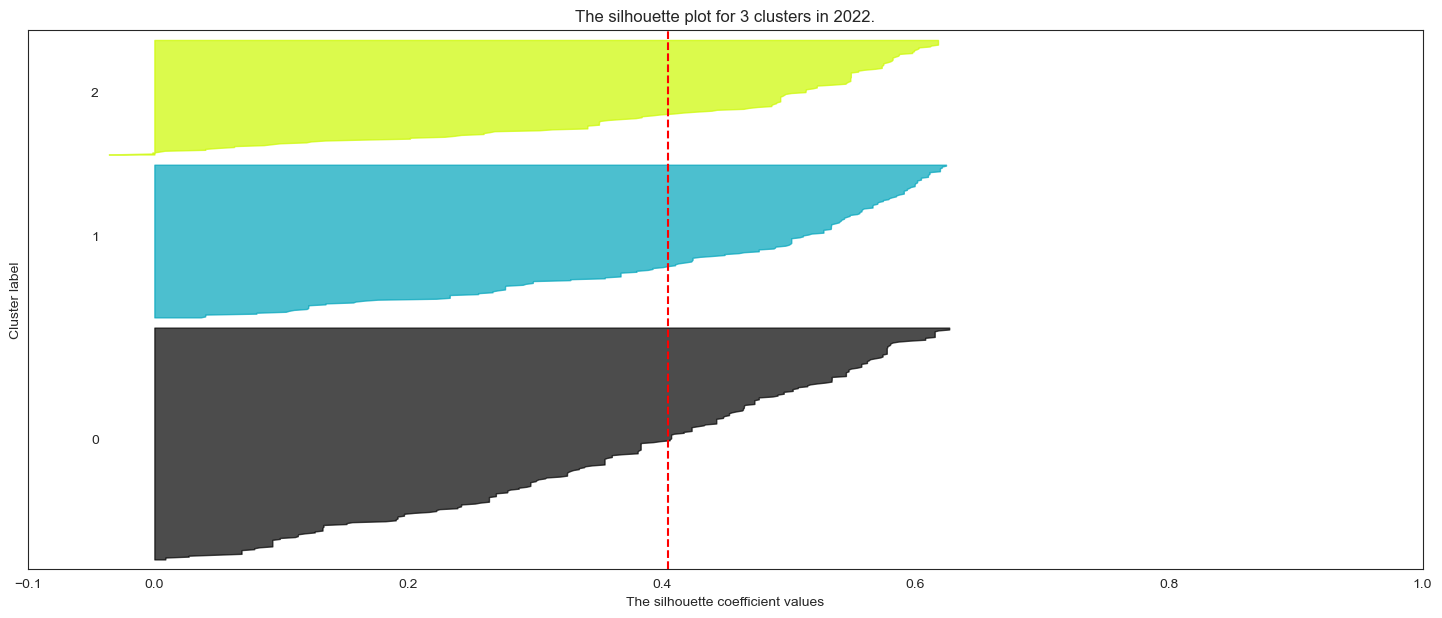

In [69]:
range_n_clusters = [3]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_2022) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,
                       n_init=100,
                       max_iter=500,
                       random_state=42)
    
    cluster_labels = clusterer.fit_predict(X_2022)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_2022, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_2022, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for 3 clusters in 2022.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [73]:
jason_kidd_2005, league_avg = get_player_shotchartdetail('Jason Kidd', '2005-06')
# kirk_hinrich_2005 = get_player_shotchartdetail('Kirk Hinrich ', '2005-06')
deron_williams_2005, league_avg = get_player_shotchartdetail('Deron Williams', '2005-06')
mike_bibby_2005, league_avg = get_player_shotchartdetail('Mike Bibby', '2005-06')

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



In [76]:
allen_iverson_2005, league_avg = get_player_shotchartdetail('Allen Iverson', '2005-06')
tj_ford_2005, league_avg = get_player_shotchartdetail('T.J. Ford', '2005-06')
luke_ridnour_2005, league_avg = get_player_shotchartdetail('Luke Ridnour', '2005-06')
baron_davis_2005, league_avg = get_player_shotchartdetail('Baron Davis', '2005-06')
delonte_west_2005, league_avg = get_player_shotchartdetail('Delonte West', '2005-06')
jason_williams_2005, league_avg = get_player_shotchartdetail('Jason Williams', '2005-06')
marko_jaric_2005, league_avg = get_player_shotchartdetail('Marko Jaric', '2005-06')
tony_parker_2005, league_avg = get_player_shotchartdetail('Tony Parker', '2005-06')
mike_james_2005, league_avg = get_player_shotchartdetail('Mike James', '2005-06')
gilbert_arenas_2005, league_avg = get_player_shotchartdetail('Gilbert Arenas', '2005-06')
steve_blake_2005, league_avg = get_player_shotchartdetail('Steve Blake', '2005-06')
jason_terry_2005, league_avg = get_player_shotchartdetail('Jason Terry', '2005-06')
stephon_marbury_2005, league_avg = get_player_shotchartdetail('Stephon Marbury', '2005-06')
# steve_francis_2005, league_avg = get_player_shotchartdetail('Steve Francis', '2005-06')
# chucky_atkins_2005, league_avg = get_player_shotchartdetail('Chucky Atkins', '2005-06')
chauncey_billups_2005, league_avg = get_player_shotchartdetail('Chauncey Billups', '2005-06')
raymond_felton_2005, league_avg = get_player_shotchartdetail('Raymond Felton', '2005-06')
chris_paul_2005, league_avg = get_player_shotchartdetail('Chris Paul', '2005-06')
sam_cassell_2005, league_avg = get_player_shotchartdetail('Sam Cassell', '2005-06')
eric_snow_2005, league_avg = get_player_shotchartdetail('Luke Ridnour', '2005-06')
royal_ivey_2005, league_avg = get_player_shotchartdetail('Royal Ivey', '2005-06')
smush_parker_2005, league_avg = get_player_shotchartdetail('Smush Parker', '2005-06')
rafer_alston_2005, league_avg = get_player_shotchartdetail('Rafer Alston', '2005-06')
anthony_johnson_2005, league_avg = get_player_shotchartdetail('Anthony Johnson', '2005-06')
andre_miller_2005, league_avg = get_player_shotchartdetail('Andre Miller', '2005-06')

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError 

In [77]:
pg_2005_list = [allen_iverson_2005, tj_ford_2005, luke_ridnour_2005, baron_davis_2005, delonte_west_2005, jason_williams_2005, marko_jaric_2005, tony_parker_2005, mike_james_2005, gilbert_arenas_2005, steve_blake_2005, jason_terry_2005, stephon_marbury_2005, chauncey_billups_2005, raymond_felton_2005, chris_paul_2005, sam_cassell_2005, eric_snow_2005, royal_ivey_2005, smush_parker_2005, rafer_alston_2005, anthony_johnson_2005, andre_miller_2005, steve_nash
]

pg_2005 = pd.concat(pg_2005_list, ignore_index=True)

In [79]:
nenad_krstic_2005, league_avg = get_player_shotchartdetail('Nenad Krstic', '2005-06')
tyson_chandler_2005, league_avg = get_player_shotchartdetail('Tyson Chandler', '2005-06')
jarron_collins_2005, league_avg = get_player_shotchartdetail('Jarron Collins', '2005-06')
brad_miller_2005, league_avg = get_player_shotchartdetail('Brad Miller', '2005-06')
dalembert_2005, league_avg = get_player_shotchartdetail('Samuel Dalembert', '2005-06')
bogut, league_avg = get_player_shotchartdetail('Andrew Bogut', '2005-06')
petro, league_avg = get_player_shotchartdetail('Johan Petro', '2005-06')
foyle, league_avg = get_player_shotchartdetail('Adonal Foyle', '2005-06')
lafrentz, league_avg = get_player_shotchartdetail('Raef LaFrentz', '2005-06')
oneal, league_avg = get_player_shotchartdetail("Shaquille O'Neal", '2005-06')
nesterovic, league_avg = get_player_shotchartdetail('Rasho Nesterovic', '2005-06')
villanueva, league_avg = get_player_shotchartdetail('Charlie Villanueva', '2005-06')
haywood, league_avg = get_player_shotchartdetail('Brendan Haywood', '2005-06')
przybilla, league_avg = get_player_shotchartdetail('Joel Przybilla', '2005-06')
diop, league_avg = get_player_shotchartdetail('DeSagana Diop', '2005-06')
eddy_curry, league_avg = get_player_shotchartdetail('Eddy Curry', '2005-06')
howard, league_avg = get_player_shotchartdetail('Dwight Howard', '2005-06')
kurt_thomas, league_avg = get_player_shotchartdetail('Kurt Thomas', '2005-06')
lorenzen, league_avg = get_player_shotchartdetail('Lorenzen Wright', '2005-06')
wallace, league_avg = get_player_shotchartdetail('Ben Wallace', '2005-06')
brezec, league_avg = get_player_shotchartdetail('Primoz Brezec', '2005-06')
kaman, league_avg = get_player_shotchartdetail('Chris Kaman', '2005-06')
david_west, league_avg = get_player_shotchartdetail('David West', '2005-06')
ilgauskas, league_avg = get_player_shotchartdetail('Zydrunas Ilgauskas', '2005-06')
pachulia, league_avg = get_player_shotchartdetail('Zaza Pachulia', '2005-06')
mihm, league_avg = get_player_shotchartdetail('Chris Mihm', '2005-06')
ming, league_avg = get_player_shotchartdetail('Yao Ming', '2005-06')
foster, league_avg = get_player_shotchartdetail('Jeff Foster', '2005-06')
camby, league_avg = get_player_shotchartdetail('Marcus Camby', '2005-06')

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError 

In [80]:
center_2005_list = [nenad_krstic_2005, tyson_chandler_2005, jarron_collins_2005, brad_miller_2005, dalembert_2005, bogut, petro, foyle, lafrentz, oneal, nesterovic, villanueva, haywood, przybilla, diop, eddy_curry, howard, kurt_thomas, lorenzen, wallace, brezec, kaman, david_west, ilgauskas, pachulia, mihm, ming, foster, camby]

center_2005 = pd.concat(center_2005_list, ignore_index=True)

In [88]:
maxey, league_avg = get_player_shotchartdetail('Tyrese Maxey', '2022-23')
holiday, league_avg = get_player_shotchartdetail('Jrue Holiday', '2022-23')
garland, league_avg = get_player_shotchartdetail('Darius Garland', '2022-23')
smart, league_avg = get_player_shotchartdetail('Marcus Smart', '2022-23')
morant, league_avg = get_player_shotchartdetail('Ja Morant', '2022-23')
young, league_avg = get_player_shotchartdetail('Trae Young', '2022-23')
lowry, league_avg = get_player_shotchartdetail('Kyle Lowry', '2022-23')
ball, league_avg = get_player_shotchartdetail('LaMelo Ball', '2022-23')
sexton, league_avg = get_player_shotchartdetail('Collin Sexton', '2022-23')
fox, league_avg = get_player_shotchartdetail("De'Aaron Fox", '2022-23')
brunson, league_avg = get_player_shotchartdetail('Jalen Brunson', '2022-23')
fultz, league_avg = get_player_shotchartdetail('Markelle Fultz', '2022-23')
doncic, league_avg = get_player_shotchartdetail('Luka Doncic', '2022-23')
murray, league_avg = get_player_shotchartdetail('Jamal Murray', '2022-23')
haliburton, league_avg = get_player_shotchartdetail('Tyrese Haliburton', '2022-23')
hayes, league_avg = get_player_shotchartdetail('Killian Hayes', '2022-23')
vanvleet, league_avg = get_player_shotchartdetail('Fred VanVleet', '2022-23')
porterjr, league_avg = get_player_shotchartdetail('Kevin Porter Jr.', '2022-23')
jones, league_avg = get_player_shotchartdetail('Tre Jones', '2022-23')
paul, league_avg = get_player_shotchartdetail('Chris Paul', '2022-23')
sga, league_avg = get_player_shotchartdetail('Shai Gilgeous-Alexander', '2022-23')
lillard, league_avg = get_player_shotchartdetail('Damian Lillard', '2022-23')
curry, league_avg = get_player_shotchartdetail('Stephen Curry', '2022-23')
morris, league_avg = get_player_shotchartdetail('Monte Morris', '2022-23')


C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



In [89]:
pg_2022_list = [maxey, holiday, garland, smart, morant, young, lowry, ball, sexton, fox, brunson, fultz, doncic, murray, haliburton, hayes, vanvleet, porterjr, jones, paul, sga, lillard, curry, morris]

pg_2022 = pd.concat(pg_2022_list, ignore_index=True)

In [90]:
embiid, league_avg = get_player_shotchartdetail('Joel Embiid', '2022-23')
lopez, league_avg = get_player_shotchartdetail('Brook Lopez', '2022-23')
vucevic, league_avg = get_player_shotchartdetail('Nikola Vucevic', '2022-23')
allen, league_avg = get_player_shotchartdetail('Jarrett Allen', '2022-23')
williams, league_avg = get_player_shotchartdetail('Robert Williams III', '2022-23')
zubac, league_avg = get_player_shotchartdetail('Ivica Zubac', '2022-23')
adams, league_avg = get_player_shotchartdetail('Steven Adams', '2022-23')
capela, league_avg = get_player_shotchartdetail('Clint Capela', '2022-23')
adebayo, league_avg = get_player_shotchartdetail('Bam Adebayo', '2022-23')
williams, league_avg = get_player_shotchartdetail('Mark Williams', '2022-23')
kessler, league_avg = get_player_shotchartdetail('Walker Kessler', '2022-23')
sabonis, league_avg = get_player_shotchartdetail('Domantas Sabonis', '2022-23')
robinson, league_avg = get_player_shotchartdetail('Mitchell Robinson', '2022-23')
davis, league_avg = get_player_shotchartdetail('Anthony Davis', '2022-23')
carter, league_avg = get_player_shotchartdetail('Wendell Carter Jr.', '2022-23')
powell, league_avg = get_player_shotchartdetail('Dwight Powell', '2022-23')
claxton, league_avg = get_player_shotchartdetail('Nic Claxton', '2022-23')
jokic, league_avg = get_player_shotchartdetail('Nikola Jokic', '2022-23')
turner, league_avg = get_player_shotchartdetail('Myles Turner', '2022-23')
valanciunas, league_avg = get_player_shotchartdetail('Jonas Valanciunas', '2022-23')
duren, league_avg = get_player_shotchartdetail('Jalen Duren', '2022-23')
siakam, league_avg = get_player_shotchartdetail('Pascal Siakam', '2022-23')
sengun, league_avg = get_player_shotchartdetail('Alperen Sengun', '2022-23')
collins, league_avg = get_player_shotchartdetail('Zach Collins', '2022-23')
ayton, league_avg = get_player_shotchartdetail('Deandre Ayton', '2022-23')
poku, league_avg = get_player_shotchartdetail('Aleksej Pokusevski', '2022-23')
gobert, league_avg = get_player_shotchartdetail('Rudy Gobert', '2022-23')
nurkic, league_avg = get_player_shotchartdetail('Jusuf Nurkic', '2022-23')
looney, league_avg = get_player_shotchartdetail('Kevon Looney', '2022-23')
gafford, league_avg = get_player_shotchartdetail('Daniel Gafford', '2022-23')


C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\2687757532.py:21: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError 

In [91]:
center_2022_list = [embiid, lopez, vucevic, allen, williams, zubac, adams, capela, adebayo, williams, kessler, sabonis, robinson, davis, carter, powell, claxton, jokic, turner, valanciunas, duren, siakam, sengun, collins, ayton, poku, gobert, nurkic, looney, gafford]

center_2022 = pd.concat(center_2022_list, ignore_index=True)

In [96]:
def sized_hexbin(ax, hc, hc2, cmap, norm):
    offsets = hc.get_offsets()
    orgpath = hc.get_paths()[0]
    verts = orgpath.vertices
    values1 = hc.get_array()
    values2 = hc2.get_array()
    ma = values1.max()
    patches = []

    for offset,val in zip(offsets,values1):
        # Adding condition for minimum size 
        # offset is the respective position of each hexagons
        
        # remove 0 to compare frequency without 0s
        filtered_list = list(filter(lambda num: num != 0, values1))
        
        # we also skip frequency counts that are 0s
        # this is to discount hexbins with no occurences
        # default value hexagons are the frequencies
        if (int(val) == 0):
            continue
        elif (percentileofscore(filtered_list, val) < 33.33):
            #print(percentileofscore(values1, val))
            #print("bot")
            v1 = verts*0.3 + offset
        elif (percentileofscore(filtered_list, val) > 69.99):
            #print(percentileofscore(values1, val))
            #print("top")
            v1 = verts + offset
        else:
            #print("mid")
            v1 = verts*0.6 + offset
        
        path = Path(v1, orgpath.codes)
        patch = PathPatch(path)
        patches.append(patch)

    pc = PatchCollection(patches, cmap=cmap, norm=norm)
    # sets color
    # so hexbin with C=data['FGP']
    pc.set_array(values2)

    ax.add_collection(pc)
    hc.remove()
    hc2.remove()

def hexmap_chart(data, league_avg, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="#1a477b", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):
    
    LA = league_avg.loc[:,['SHOT_ZONE_AREA','SHOT_ZONE_RANGE', 'FGA', 'FGM']].groupby(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    LA['FGP'] = 1.0*LA['FGM']/LA['FGA']
    player = data.groupby(['SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_MADE_FLAG']).size().unstack(fill_value=0)
    player['FGP'] = 1.0*player.loc[:,1]/player.sum(axis=1)
    player_vs_league = (player.loc[:,'FGP'] - LA.loc[:,'FGP'])*100  

    data = pd.merge(data, player_vs_league, on=['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], how='right')
    
    if ax is None:
        ax = plt.gca()
        ax.set_facecolor(court_color)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    x = data['LOC_X']
    y = data['LOC_Y']
        
    # for diverging color map
    colors = ['#2b7cb6', '#abd9e9', '#ffffbf', '#fdaf61', '#d7191c']
    cmap = ListedColormap(colors)
    # The 5 colors are separated by -9, -3, 0, 3, 9
    boundaries = [-np.inf, -9, -3, 3, 9, np.inf]
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)   
    
    # first hexbin required for bincount
    # second hexbin for the coloring of each hexagons
    hexbin = ax.hexbin(x, y, gridsize=40, cmap=cmap, norm=norm, extent=[-275, 275, -50, 425])
    hexbin2 = ax.hexbin(x, y, C=data['FGP'], gridsize=40, cmap=cmap, norm=norm, extent=[-275, 275, -50, 425])
    sized_hexbin(ax, hexbin, hexbin2, cmap, norm) 
    
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

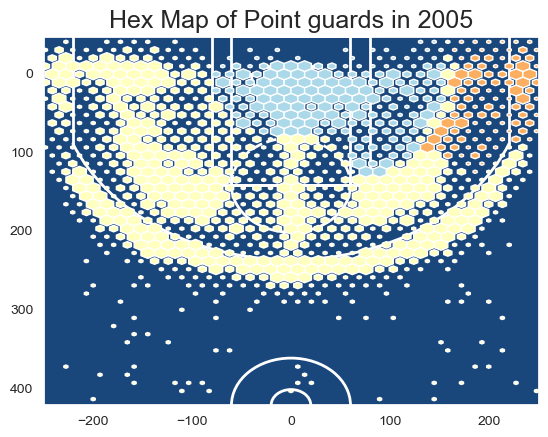

In [97]:
hexmap_chart(pg_2005, league_avg, title="Hex Map of Point guards in 2005")
plt.show()

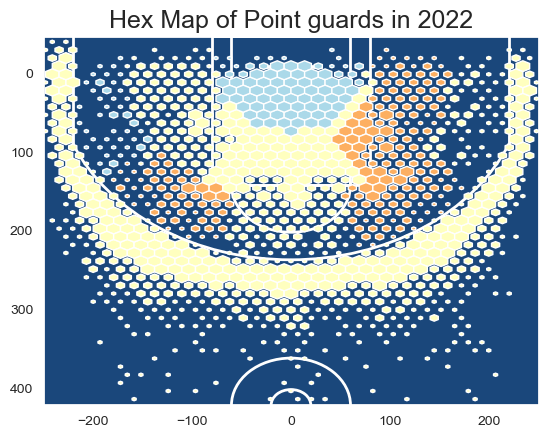

In [113]:
hexmap_chart(pg_2022, league_avg, title="Hex Map of Point guards in 2022")
plt.show()

In [103]:
def heatmap(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="white", court_lw=2, outer_lines=True,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)
    
    x = data['LOC_X']
    y = data['LOC_Y']
    
    sns.kdeplot(x=x, y=y, fill=True, cmap='inferno', ax=ax, **kwargs)

    ax.scatter(x, y, facecolors='w', s=2, linewidths=0.1, **kwargs)
    
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

<AxesSubplot:xlabel='LOC_X', ylabel='LOC_Y'>

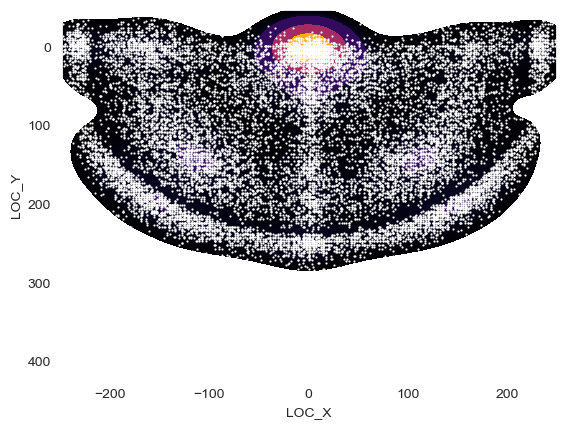

In [104]:
heatmap(pg_2005)

In [105]:
pg_2005.to_csv('pointguard2005.csv')

C:\Users\Cm1Bm\AppData\Local\Temp\ipykernel_58076\1214119977.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




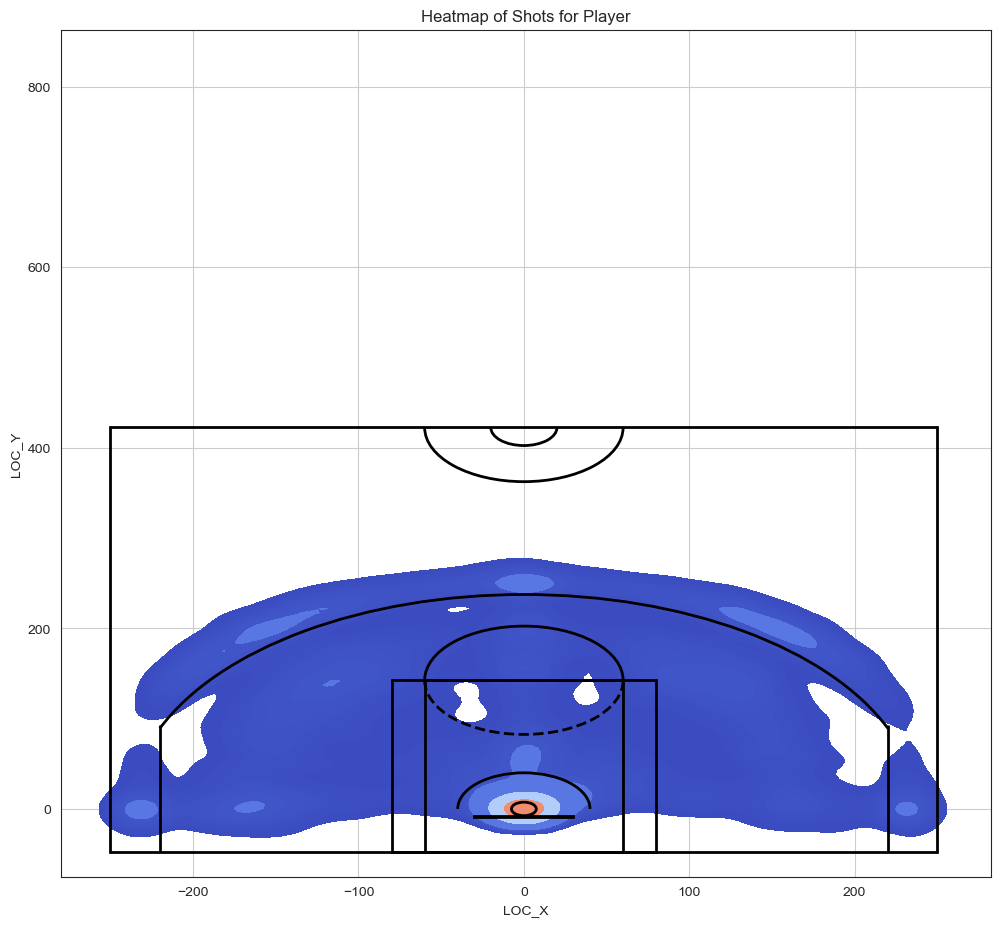

In [112]:
# Correcting the syntax for kdeplot in the heatmap
plt.figure(figsize=(12, 11))
sns.kdeplot(x=pg_2005['LOC_X'], y=pg_2005['LOC_Y'], cmap="coolwarm", shade=True, bw_adjust=0.5)

# Setting up the plot
plt.title('Heatmap of Shots for Player')
plt.xlabel('LOC_X')
plt.ylabel('LOC_Y')
draw_court(outer_lines=True)
plt.grid(True)
plt.show()

In [124]:
from scipy.stats import binned_statistic_2d


def heatmaptest(x, y, z, title="", cmap=plt.cm.YlOrRd, bins=20,
            xlim=(-250, 250), ylim=(422.5, -47.5),
            facecolor='lightgray', facecolor_alpha=0.4,
            court_color="black", court_lw=0.5, outer_lines=False,
            flip_court=False, ax=None, **kwargs):

    """
    Returns an AxesImage object that contains a heatmap.

    TODO: Redo some code and explain parameters
    """

    # Bin the FGA (x, y) and Calculcate the mean number of times shot was
    # made (z) within each bin
    # mean is the calculated FG percentage for each bin
    mean, xedges, yedges, binnumber = binned_statistic_2d(x=x, y=y,
                                                          values=z,
                                                          statistic='mean',
                                                          bins=bins)

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    ax.patch.set_facecolor(facecolor)
    ax.patch.set_alpha(facecolor_alpha)

    draw_court(ax, color=court_color, lw=court_lw, outer_lines=outer_lines)

    heatmaptest = ax.imshow(mean.T, origin='lower', extent=[xedges[0], xedges[-1],
                        yedges[0], yedges[-1]], interpolation='nearest',
                        cmap=cmap)

    return heatmaptest


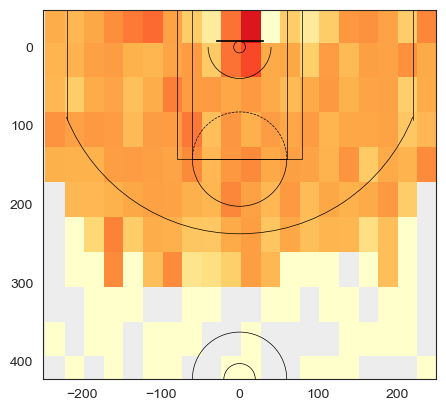

In [125]:
heatmaptest(pg_2005['LOC_X'], pg_2005['LOC_Y'], pg_2005['SHOT_MADE_FLAG'])

In [129]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from math import pi


def bokeh_draw_court(figure, line_color='gray', line_width=1):
    """Returns a figure with the basketball court lines drawn onto it

    This function draws a court based on the x and y-axis values that the NBA
    stats API provides for the shot chart data.  For example the center of the
    hoop is located at the (0,0) coordinate.  Twenty-two feet from the left of
    the center of the hoop in is represented by the (-220,0) coordinates.
    So one foot equals +/-10 units on the x and y-axis.

    Parameters
    ----------
    figure : Bokeh figure object
        The Axes object to plot the court onto.
    line_color : str, optional
        The color of the court lines. Can be a a Hex value.
    line_width : float, optional
        The linewidth the of the court lines in pixels.

    Returns
    -------
    figure : Figure
        The Figure object with the court on it.

    """

    # hoop
    figure.circle(x=0, y=0, radius=7.5, fill_alpha=0,
                  line_color=line_color, line_width=line_width)

    # backboard
    figure.line(x=range(-30, 31), y=-12.5, line_color=line_color)

    # The paint
    # outerbox
    figure.rect(x=0, y=47.5, width=160, height=190, fill_alpha=0,
                line_color=line_color, line_width=line_width)
    # innerbox
    # left inner box line
    figure.line(x=-60, y=np.arange(-47.5, 143.5), line_color=line_color,
                line_width=line_width)
    # right inner box line
    figure.line(x=60, y=np.arange(-47.5, 143.5), line_color=line_color,
                line_width=line_width)

    # Restricted Zone
    figure.arc(x=0, y=0, radius=40, start_angle=pi, end_angle=0,
               line_color=line_color, line_width=line_width)

    # top free throw arc
    figure.arc(x=0, y=142.5, radius=60, start_angle=pi, end_angle=0,
               line_color=line_color)

    # bottome free throw arc
    figure.arc(x=0, y=142.5, radius=60, start_angle=0, end_angle=pi,
               line_color=line_color, line_dash="dashed")

    # Three point line
    # corner three point lines
    figure.line(x=-220, y=np.arange(-47.5, 92.5), line_color=line_color,
                line_width=line_width)
    figure.line(x=220, y=np.arange(-47.5, 92.5), line_color=line_color,
                line_width=line_width)
    # # three point arc
    figure.arc(x=0, y=0, radius=237.5, start_angle=3.528, end_angle=-0.3863,
               line_color=line_color, line_width=line_width)

    # add center court
    # outer center arc
    figure.arc(x=0, y=422.5, radius=60, start_angle=0, end_angle=pi,
               line_color=line_color, line_width=line_width)
    # inner center arct
    figure.arc(x=0, y=422.5, radius=20, start_angle=0, end_angle=pi,
               line_color=line_color, line_width=line_width)

    # outer lines, consistting of half court lines and out of bounds lines
    figure.rect(x=0, y=187.5, width=500, height=470, fill_alpha=0,
                line_color=line_color, line_width=line_width)

    return figure


def bokeh_shot_chart(data, x="LOC_X", y="LOC_Y", fill_color="#1f77b4",
                     scatter_size=10, fill_alpha=0.4, line_alpha=0.4,
                     court_line_color='gray', court_line_width=1,
                     hover_tool=False, tooltips=None, **kwargs):

    # TODO: Settings for hover tooltip
    """
    Returns a figure with both FGA and basketball court lines drawn onto it.

    This function expects data to be a ColumnDataSource with the x and y values
    named "LOC_X" and "LOC_Y".  Otherwise specify x and y.

    Parameters
    ----------

    data : DataFrame
        The DataFrame that contains the shot chart data.
    x, y : str, optional
        The x and y coordinates of the shots taken.
    fill_color : str, optional
        The fill color of the shots. Can be a a Hex value.
    scatter_size : int, optional
        The size of the dots for the scatter plot.
    fill_alpha : float, optional
        Alpha value for the shots. Must be a floating point value between 0
        (transparent) to 1 (opaque).
    line_alpha : float, optiona
        Alpha value for the outer lines of the plotted shots. Must be a
        floating point value between 0 (transparent) to 1 (opaque).
    court_line_color : str, optional
        The color of the court lines. Can be a a Hex value.
    court_line_width : float, optional
        The linewidth the of the court lines in pixels.
    hover_tool : boolean, optional
        If ``True``, creates hover tooltip for the plot.
    tooltips : List of tuples, optional
        Provides the information for the the hover tooltip.

    Returns
    -------
    fig : Figure
        The Figure object with the shot chart plotted on it.

    """
    source = ColumnDataSource(data)

    fig = figure(width=700, height=658, x_range=[-250, 250],
                 y_range=[422.5, -47.5], min_border=0, x_axis_type=None,
                 y_axis_type=None, outline_line_color="black", **kwargs)

    fig.scatter(x, y, source=source, size=scatter_size, color=fill_color,
                alpha=fill_alpha, line_alpha=line_alpha)

    bokeh_draw_court(fig, line_color=court_line_color,
                     line_width=court_line_width)

    if hover_tool:
        hover = HoverTool(renderers=[fig.renderers[0]], tooltips=tooltips)
        fig.add_tools(hover)

    return fig

In [133]:
def shot_chart_jointplot(x, y, data=None, kind="scatter", title="", color="b",
                         cmap=None, xlim=(-250, 250), ylim=(422.5, -47.5),
                         court_color="gray", court_lw=1, outer_lines=False,
                         flip_court=False, size=(12, 11), space=0,
                         despine=False, joint_kws=None, marginal_kws=None,
                         **kwargs):
    """
    Returns a seaborn JointGrid using sns.jointplot

    Parameters
    ----------

    x, y : strings or vector
        The x and y coordinates of the shots taken. They can be passed in as
        vectors (such as a pandas Series) or as column names from the pandas
        DataFrame passed into ``data``.
    data : DataFrame, optional
        DataFrame containing shots where ``x`` and ``y`` represent the
        shot location coordinates.
    kind : { "scatter", "kde", "hex" }, optional
        The kind of shot chart to create.
    title : str, optional
        The title for the plot.
    color : matplotlib color, optional
        Color used to plot the shots
    cmap : matplotlib Colormap object or name, optional
        Colormap for the range of data values. If one isn't provided, the
        colormap is derived from the valuue passed to ``color``. Used for KDE
        and Hexbin joint plots.
    {x, y}lim : two-tuples, optional
        The axis limits of the plot.  The defaults represent the out of bounds
        lines and half court line.
    court_color : matplotlib color, optional
        The color of the court lines.
    court_lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If ``True`` the out of bound lines are drawn in as a matplotlib
        Rectangle.
    flip_court : boolean, optional
        If ``True`` orients the hoop towards the bottom of the plot.  Default
        is ``False``, which orients the court where the hoop is towards the top
        of the plot.
    gridsize : int, optional
        Number of hexagons in the x-direction.  The default is calculated using
        the Freedman-Diaconis method.
    size : tuple, optional
        The width and height of the plot in inches.
    space : numeric, optional
        The space between the joint and marginal plots.
    {joint, marginal}_kws : dicts
        Additional kewyord arguments for joint and marginal plot components.
    kwargs : key, value pairs
        Keyword arguments for matplotlib Collection properties or seaborn plots.

    Returns
    -------
     grid : JointGrid
        The JointGrid object with the shot chart plotted on it.

   """

    # If a colormap is not provided, then it is based off of the color
    if cmap is None:
        cmap = sns.light_palette(color, as_cmap=True)

    if kind not in ["scatter", "kde", "hex"]:
        raise ValueError("kind must be 'scatter', 'kde', or 'hex'.")

    grid = sns.jointplot(x=x, y=y, data=data, stat_func=None, kind=kind,
                         space=0, color=color, cmap=cmap, joint_kws=joint_kws,
                         marginal_kws=marginal_kws, **kwargs)

    grid.fig.set_size_inches(size)

    # A joint plot has 3 Axes, the first one called ax_joint
    # is the one we want to draw our court onto and adjust some other settings
    ax = grid.ax_joint

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    draw_court(ax, color=court_color, lw=court_lw, outer_lines=outer_lines)

    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom='off', labelleft='off')

    # Add a title
    ax.set_title(title, y=1.2, fontsize=18)

    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(court_color)
        # set the margin joint spines to be same as the rest of the plot
        grid.ax_marg_x.spines[spine].set_lw(court_lw)
        grid.ax_marg_x.spines[spine].set_color(court_color)
        grid.ax_marg_y.spines[spine].set_lw(court_lw)
        grid.ax_marg_y.spines[spine].set_color(court_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return grid

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1832: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\distributions.py:1176: UserWarning:

The following kwargs were not used by contour: 'stat_func'



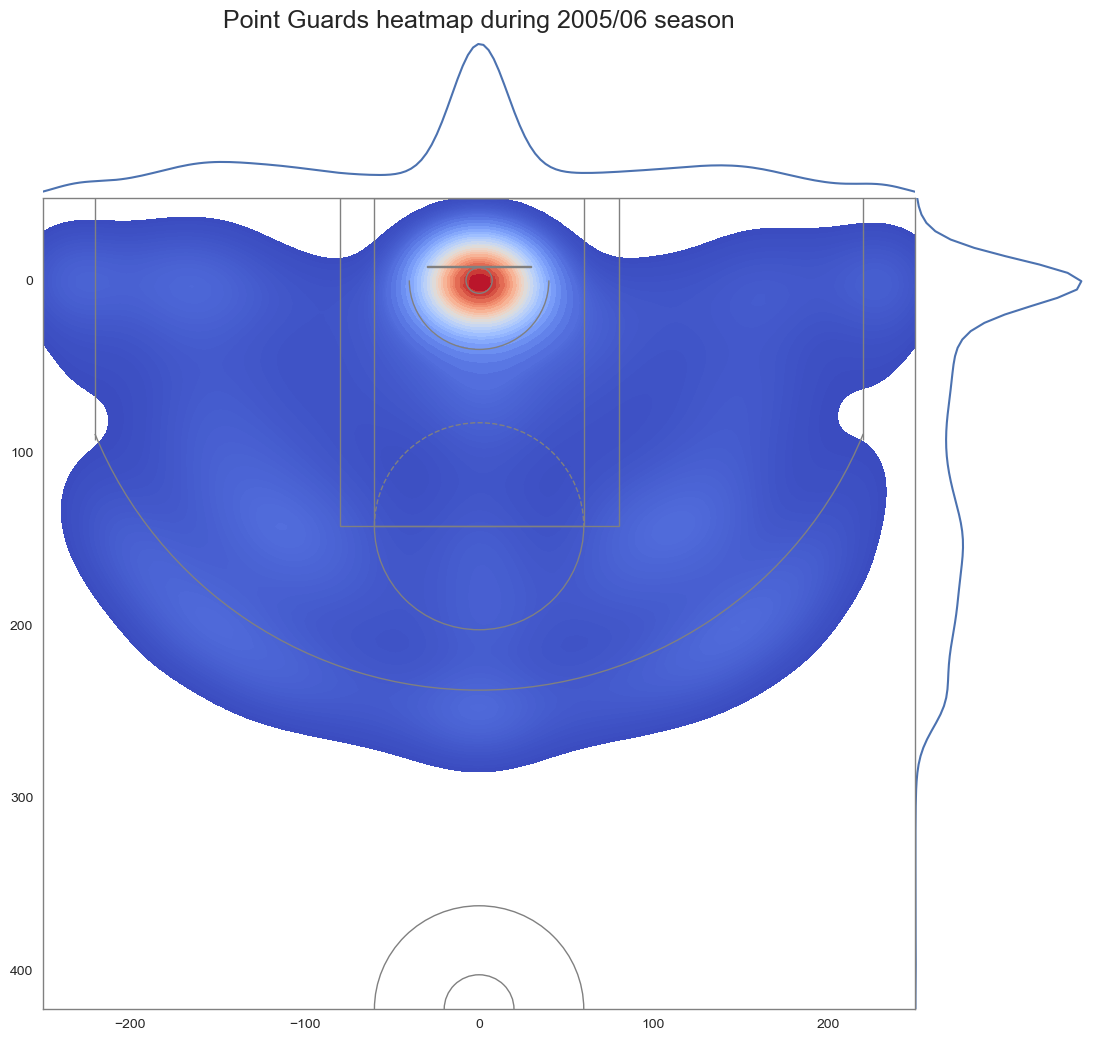

In [138]:
shot_chart_jointplot(pg_2005.LOC_X, pg_2005.LOC_Y,
                         kind="kde", title="Point Guards heatmap during 2005/06 season",
                         cmap='coolwarm', n_levels=80, shade=True)
plt.show()

In [139]:
def shot_chart_jointgrid(x, y, data=None, joint_type="scatter", title="",
                         joint_color="b", cmap=None,  xlim=(-250, 250),
                         ylim=(422.5, -47.5), court_color="gray", court_lw=1,
                         outer_lines=False, flip_court=False,
                         joint_kde_shade=True, gridsize=None,
                         marginals_color="b", marginals_type="both",
                         marginals_kde_shade=True, size=(12, 11), space=0,
                         despine=False, joint_kws=None, marginal_kws=None,
                         **kwargs):

    """
    Returns a JointGrid object containing the shot chart.

    This function allows for more flexibility in customizing your shot chart
    than the ``shot_chart_jointplot`` function.

    Parameters
    ----------

    x, y : strings or vector
        The x and y coordinates of the shots taken. They can be passed in as
        vectors (such as a pandas Series) or as columns from the pandas
        DataFrame passed into ``data``.
    data : DataFrame, optional
        DataFrame containing shots where ``x`` and ``y`` represent the shot
        location coordinates.
    joint_type : { "scatter", "kde", "hex" }, optional
        The type of shot chart for the joint plot.
    title : str, optional
        The title for the plot.
    joint_color : matplotlib color, optional
        Color used to plot the shots on the joint plot.
    cmap : matplotlib Colormap object or name, optional
        Colormap for the range of data values. If one isn't provided, the
        colormap is derived from the value passed to ``color``. Used for KDE
        and Hexbin joint plots.
    {x, y}lim : two-tuples, optional
        The axis limits of the plot.  The defaults represent the out of bounds
        lines and half court line.
    court_color : matplotlib color, optional
        The color of the court lines.
    court_lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If ``True`` the out of bound lines are drawn in as a matplotlib
        Rectangle.
    flip_court : boolean, optional
        If ``True`` orients the hoop towards the bottom of the plot. Default is
        ``False``, which orients the court where the hoop is towards the top of
        the plot.
    joint_kde_shade : boolean, optional
        Default is ``True``, which shades in the KDE contours on the joint plot.
    gridsize : int, optional
        Number of hexagons in the x-direction. The default is calculated using
        the Freedman-Diaconis method.
    marginals_color : matplotlib color, optional
        Color used to plot the shots on the marginal plots.
    marginals_type : { "both", "hist", "kde"}, optional
        The type of plot for the marginal plots.
    marginals_kde_shade : boolean, optional
        Default is ``True``, which shades in the KDE contours on the marginal
        plots.
    size : tuple, optional
        The width and height of the plot in inches.
    space : numeric, optional
        The space between the joint and marginal plots.
    despine : boolean, optional
        If ``True``, removes the spines.
    {joint, marginal}_kws : dicts
        Additional kewyord arguments for joint and marginal plot components.
    kwargs : key, value pairs
        Keyword arguments for matplotlib Collection properties or seaborn plots.

    Returns
    -------
     grid : JointGrid
        The JointGrid object with the shot chart plotted on it.

    """

    # The joint_kws and marginal_kws idea was taken from seaborn
    # Create the default empty kwargs for joint and marginal plots
    if joint_kws is None:
        joint_kws = {}
    joint_kws.update(kwargs)

    if marginal_kws is None:
        marginal_kws = {}

    # If a colormap is not provided, then it is based off of the joint_color
    if cmap is None:
        cmap = sns.light_palette(joint_color, as_cmap=True)

    # Flip the court so that the hoop is by the bottom of the plot
    if flip_court:
        xlim = xlim[::-1]
        ylim = ylim[::-1]

    # Create the JointGrid to draw the shot chart plots onto
    grid = sns.JointGrid(x=x, y=y, data=data, xlim=xlim, ylim=ylim,
                         space=space)

    # Joint Plot
    # Create the main plot of the joint shot chart
    if joint_type == "scatter":
        grid = grid.plot_joint(plt.scatter, color=joint_color, **joint_kws)

    elif joint_type == "kde":
        grid = grid.plot_joint(sns.kdeplot, cmap=cmap,
                               shade=joint_kde_shade, **joint_kws)

    elif joint_type == "hex":
        if gridsize is None:
            # Get the number of bins for hexbin using Freedman-Diaconis rule
            # This is idea was taken from seaborn, which got the calculation
            # from http://stats.stackexchange.com/questions/798/
            from seaborn.distributions import _freedman_diaconis_bins
            x_bin = _freedman_diaconis_bins(x)
            y_bin = _freedman_diaconis_bins(y)
            gridsize = int(np.mean([x_bin, y_bin]))

        grid = grid.plot_joint(plt.hexbin, gridsize=gridsize, cmap=cmap,
                               **joint_kws)

    else:
        raise ValueError("joint_type must be 'scatter', 'kde', or 'hex'.")

    # Marginal plots
    # Create the plots on the axis of the main plot of the joint shot chart.
    if marginals_type == "both":
        grid = grid.plot_marginals(sns.distplot, color=marginals_color,
                                   **marginal_kws)

    elif marginals_type == "hist":
        grid = grid.plot_marginals(sns.distplot, color=marginals_color,
                                   kde=False, **marginal_kws)

    elif marginals_type == "kde":
        grid = grid.plot_marginals(sns.kdeplot, color=marginals_color,
                                   shade=marginals_kde_shade, **marginal_kws)

    else:
        raise ValueError("marginals_type must be 'both', 'hist', or 'kde'.")

    # Set the size of the joint shot chart
    grid.fig.set_size_inches(size)

    # Extract the the first axes, which is the main plot of the
    # joint shot chart, and draw the court onto it
    ax = grid.fig.get_axes()[0]
    draw_court(ax, color=court_color, lw=court_lw, outer_lines=outer_lines)

    # Get rid of the axis labels
    grid.set_axis_labels(xlabel="", ylabel="")
    # Get rid of all tick labels
    ax.tick_params(labelbottom="off", labelleft="off")
    # Set the title above the top marginal plot
    ax.set_title(title, y=1.2, fontsize=18)

    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(court_color)
        # set the marginal spines to be the same as the rest of the spines
        grid.ax_marg_x.spines[spine].set_lw(court_lw)
        grid.ax_marg_x.spines[spine].set_color(court_color)
        grid.ax_marg_y.spines[spine].set_lw(court_lw)
        grid.ax_marg_y.spines[spine].set_color(court_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return grid


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1883: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1889: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




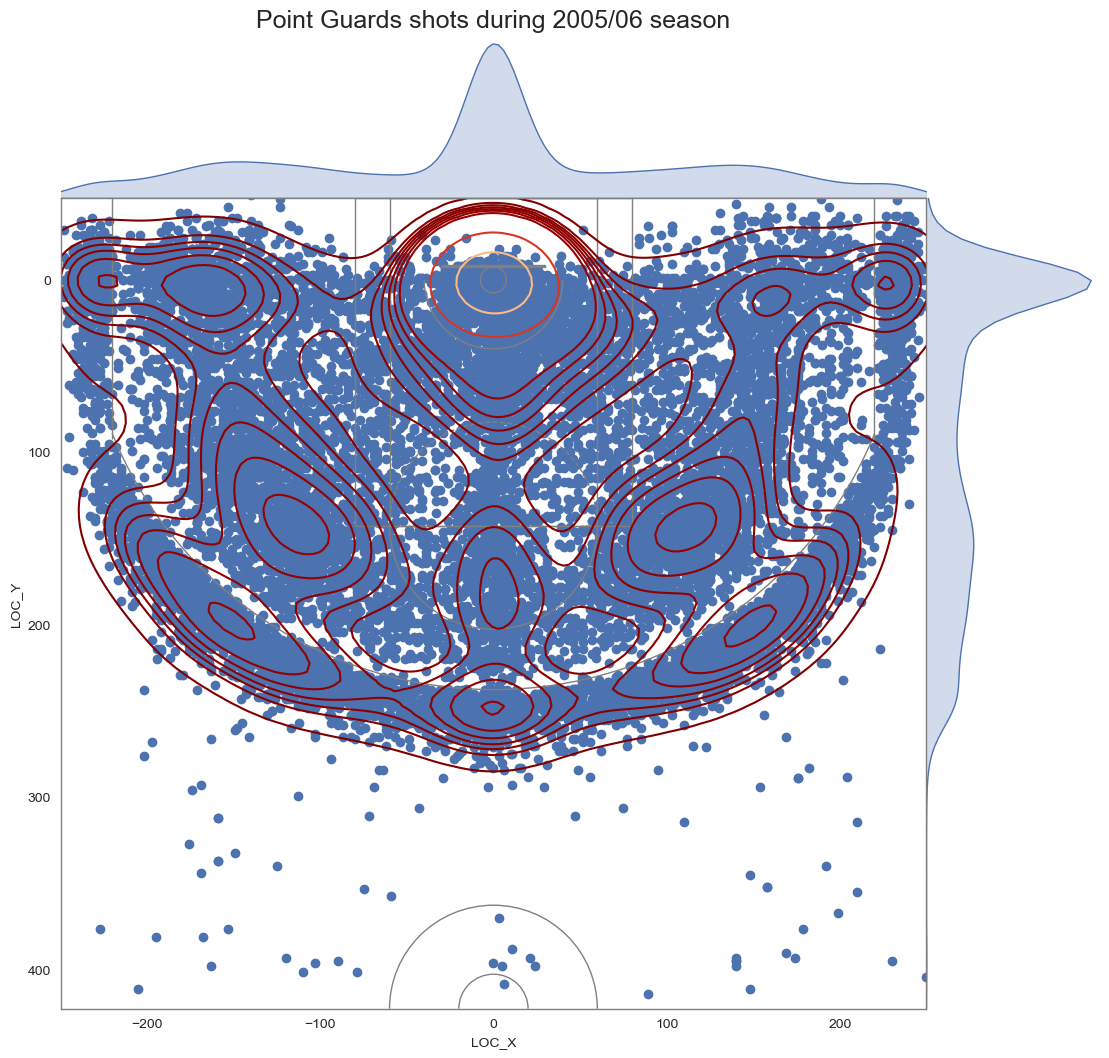

In [150]:
grid = shot_chart_jointgrid(pg_2005.LOC_X, pg_2005.LOC_Y,
                                title="Point Guards shots during 2005/06 season",
                                joint_type="scatter", cmap='magma',
                                marginals_type="kde", joint_kde_shade=False)

grid.plot_joint(sns.kdeplot, cmap=plt.cm.OrRd_r)
plt.show()

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1832: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1886: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1892: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot`

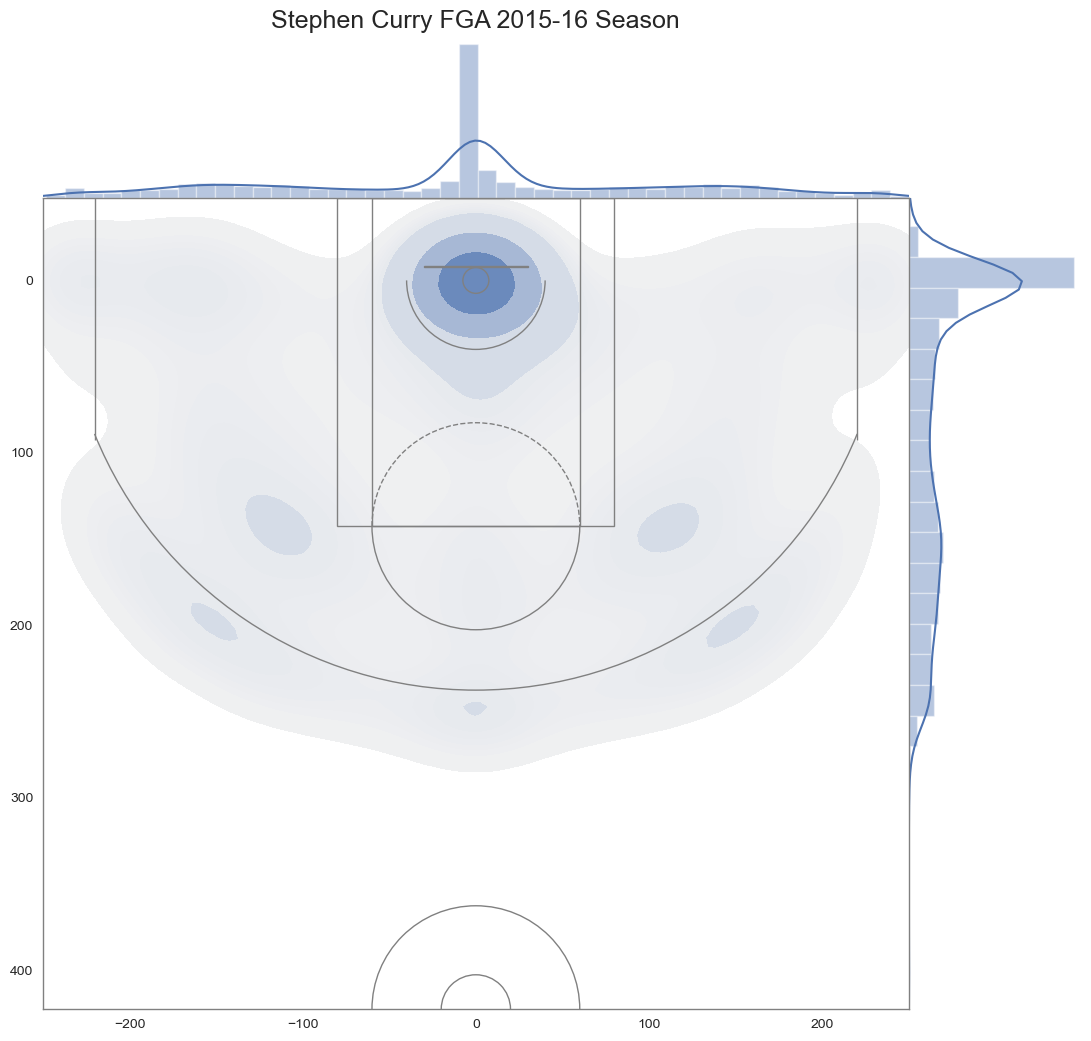

In [144]:
shot_chart_jointgrid(pg_2005.LOC_X, pg_2005.LOC_Y,
                         title="Stephen Curry FGA 2015-16 Season",
                         joint_type="kde")
plt.show()

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1832: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1886: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1892: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot`

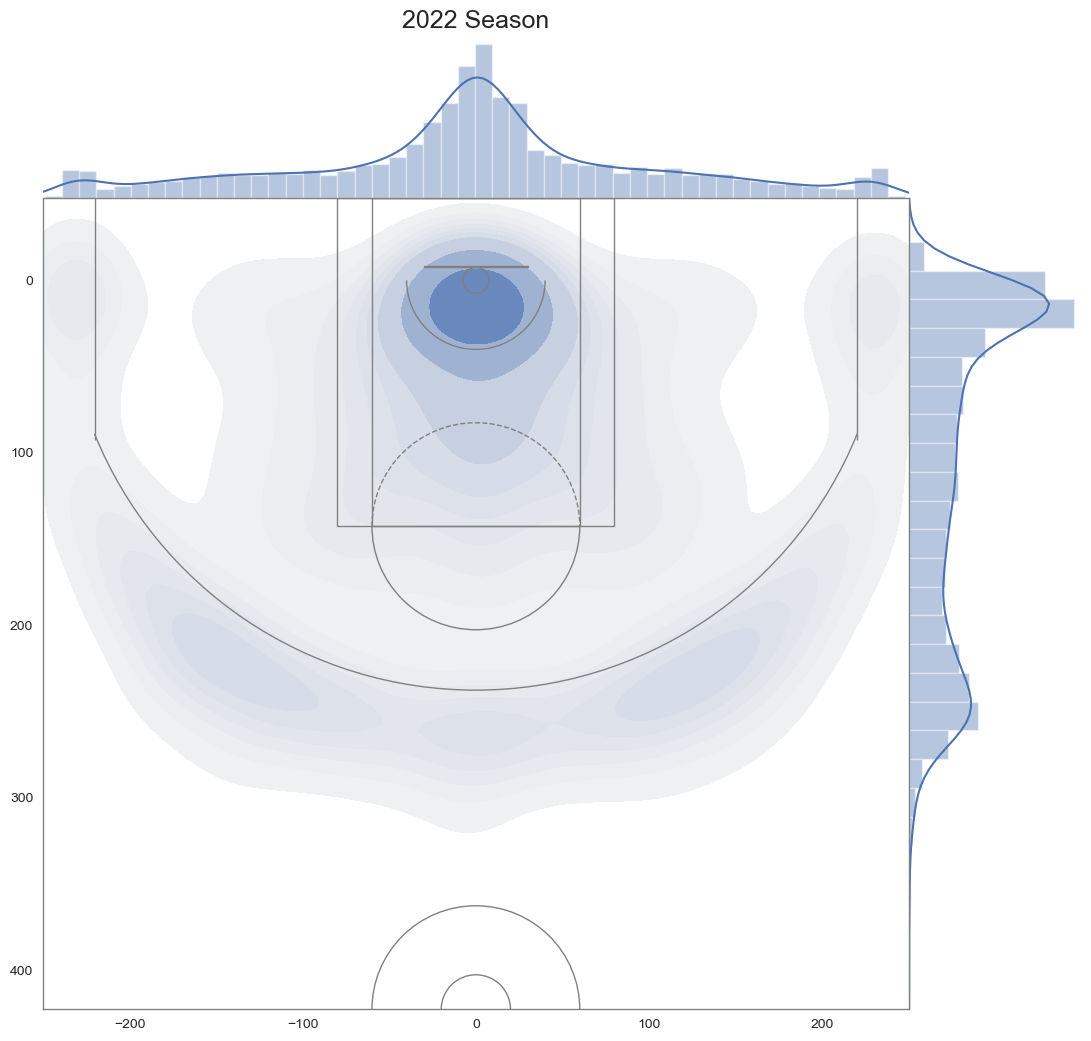

In [145]:
shot_chart_jointgrid(pg_2022.LOC_X, pg_2022.LOC_Y,
                         title="2022 Season",
                         joint_type="kde")
plt.show()

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1883: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1889: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




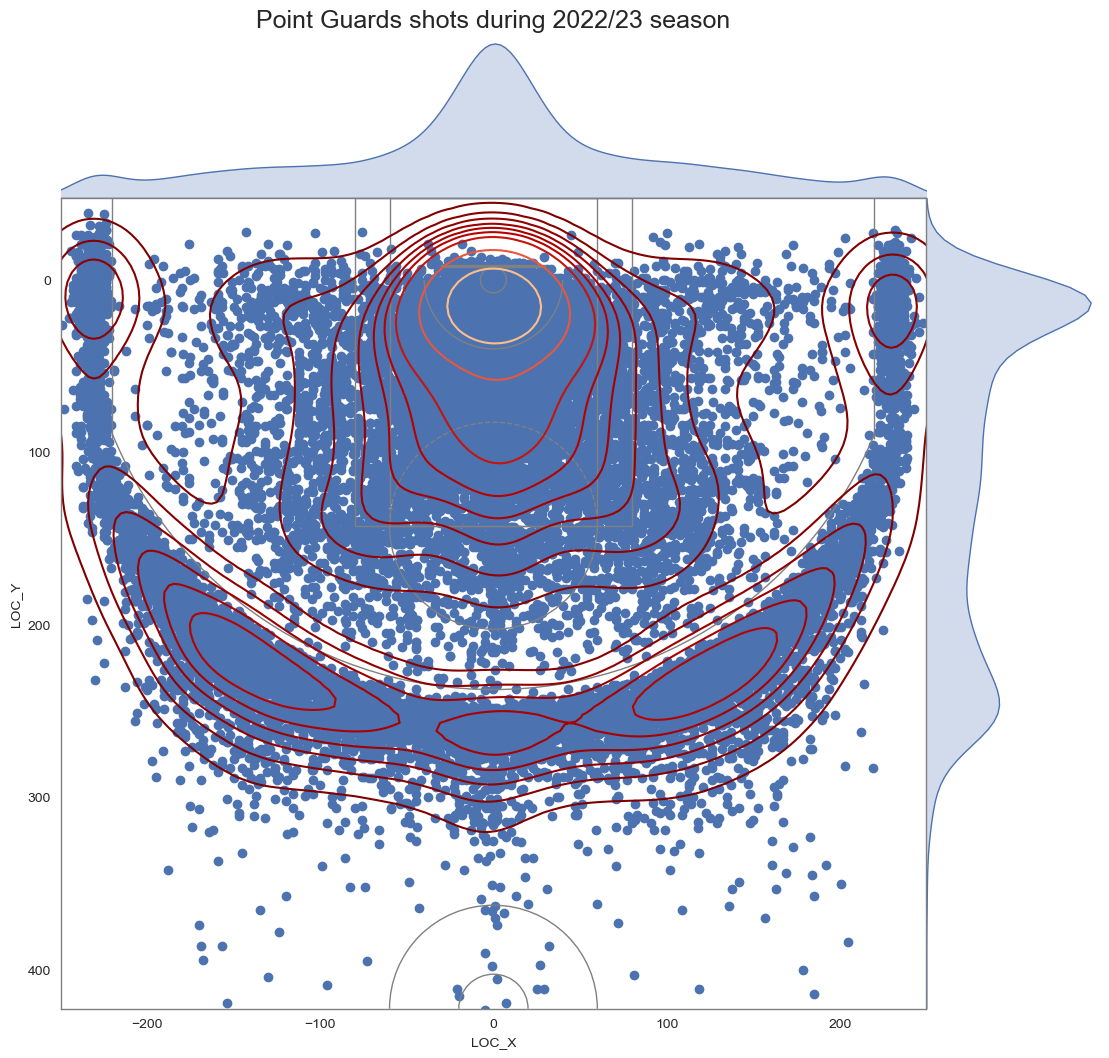

In [152]:
grid = shot_chart_jointgrid(pg_2022.LOC_X, pg_2022.LOC_Y,
                                title="Point Guards shots during 2022/23 season",
                                joint_type="scatter",
                                marginals_type="kde", joint_kde_shade=False)

grid.plot_joint(sns.kdeplot, cmap=plt.cm.OrRd_r)
plt.show()

In [ ]:
shot_chart_jointplot(pg_2022.LOC_X, pg_2022.LOC_Y,
                         kind="kde", title="Point Guards heatmap during 2005/06 season",
                         cmap='Greys', n_levels=80, shade=True)
plt.show()

c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1883: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1889: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




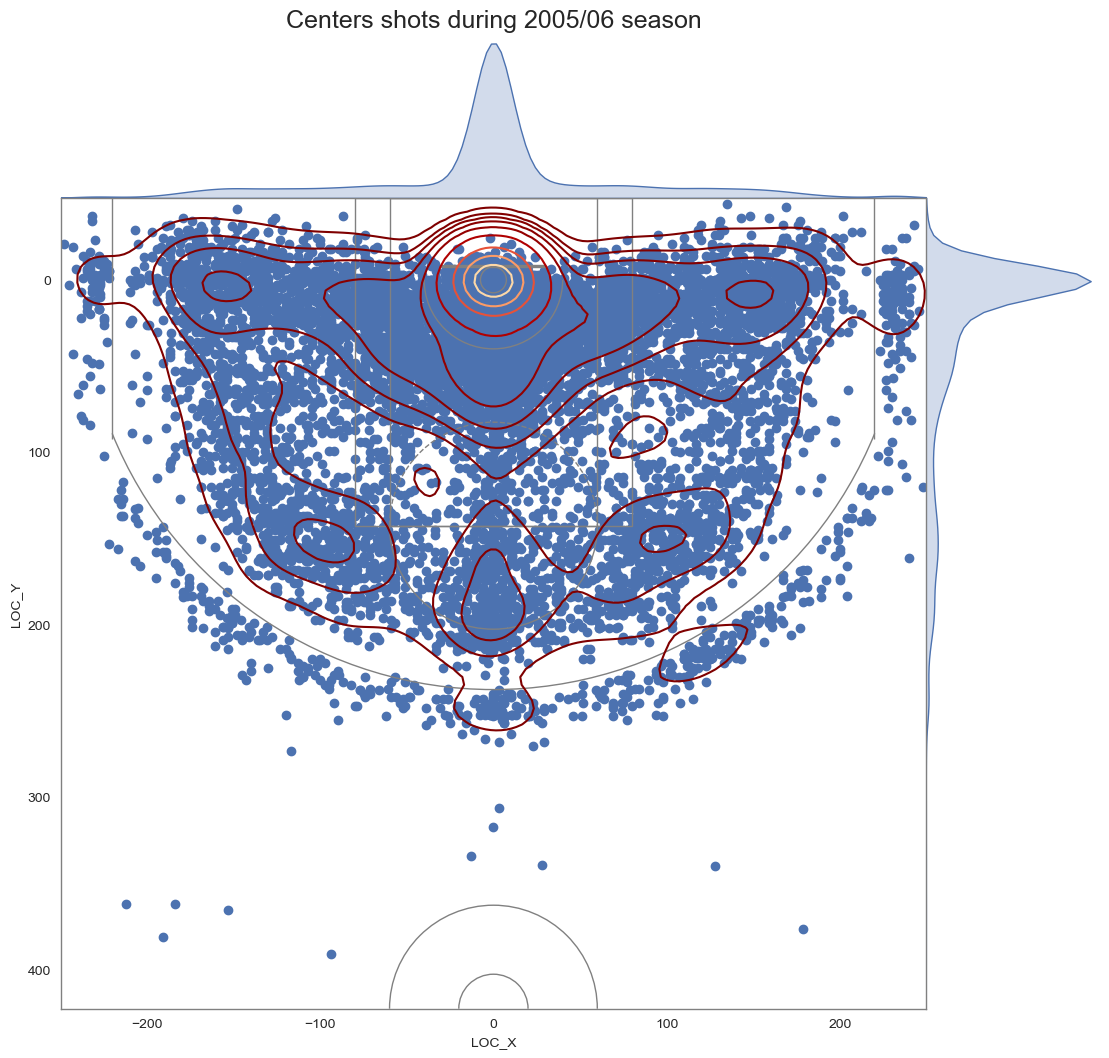

In [161]:


grid = shot_chart_jointgrid(center_2005.LOC_X, center_2005.LOC_Y,
                                title="Centers shots during 2005/06 season",
                                joint_type="scatter",
                                marginals_type="kde", joint_kde_shade=False)

grid.plot_joint(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.show()



c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1883: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\Cm1Bm\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:1889: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




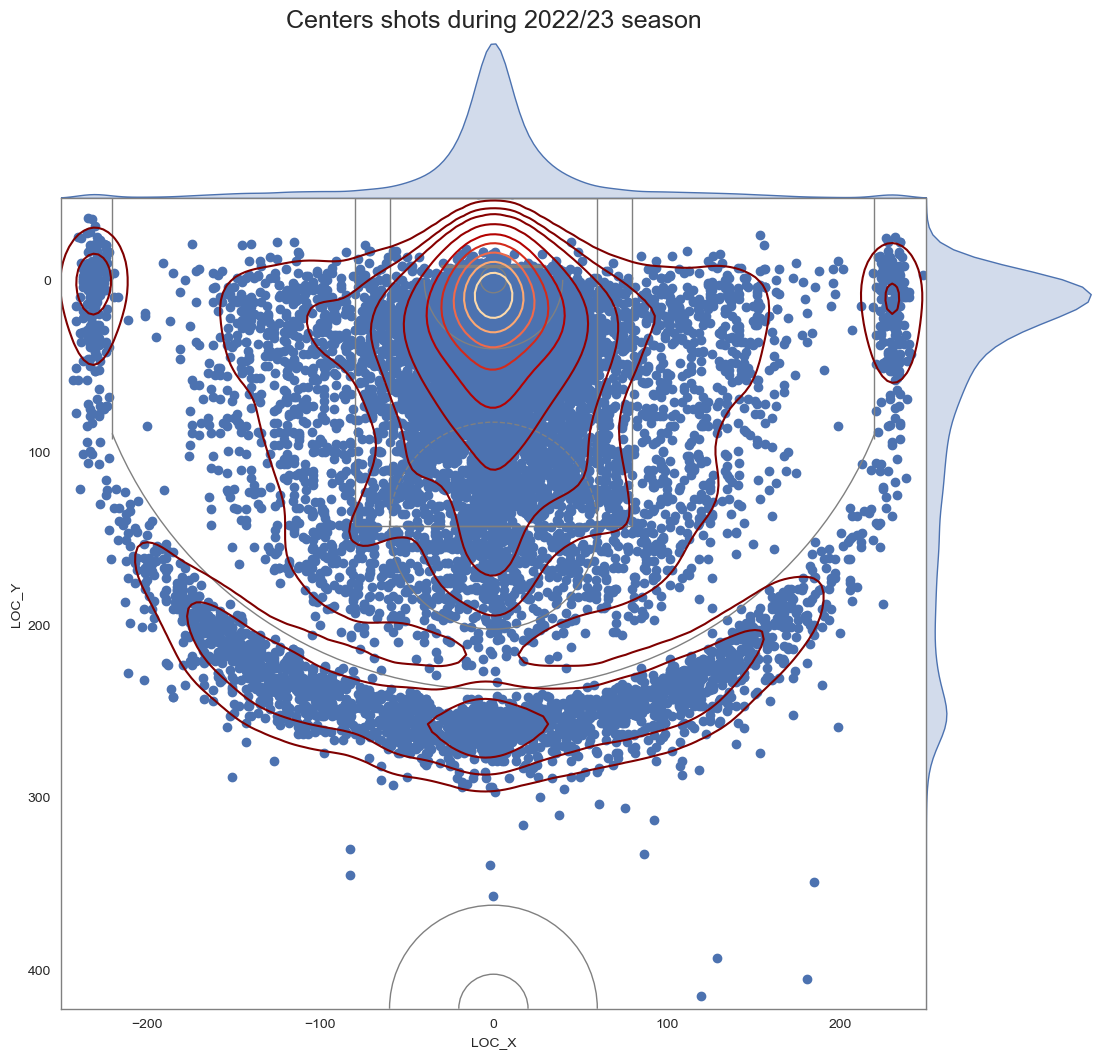

In [160]:
grid = shot_chart_jointgrid(center_2022.LOC_X, center_2022.LOC_Y,
                                title="Centers shots during 2022/23 season",
                                joint_type="scatter",
                                marginals_type="kde", joint_kde_shade=False)

grid.plot_joint(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.show()